# Python version of AWRA-L

## This workbook takes you through the AWRA-L model in detail.

The code is written in Python, rather than the core code being written in C, towards understanding the code more easily as compilation is not required. AWRA is run in two ways here :

1. Component-by-component
2. All components put together

The code is commented with reference back to the model documentation and the model is run for a year for a chosen point to understand the dynamics. 

## AWRA-L broadly follows the following workflow:

1. Pre-calculate and convert constants for use in the model
2. Initialise  models states
3. Loop over Timesteps

    - A. Calculate saturated fraction of cell/catchment for a given groundwater storage (Sg) [a single store - no HRUs]
    - B. Calculate potential evaporation (E0) according to Energy balance [for each HRU]
    - C. Calculate actual ET based on E0, water storage and vegatation state [for each HRU]
    - D. Calculate Water balance and flows [for each HRU]
    - E. Calculate Vegetation growth and senescence [for each HRU]
    - F. Get cell values of variables weighting shallow and deep rooted components depending on fraction of each

These components are coded in Python below (rather than C) to facilitate understanding and testing the AWRA-L model.

## AWRA-L model processes and algorithms overview

Structure of this notebook:

0.  Run a model simulation to get input data and AWRA-L parameters ***i***
1.  ***AWRA-L calculations deconstructed*** - run for timeperiod and parameters supplied
   - the broad steps listed above are undertaken for demonstration without timetep interaction between the energy, water and vegetation components of the model. This is to show th equations used in calculation.   
   - ***Note there is no dynamic interaction of variables in this case***. eg. fraction saturated, relative top layer soil content kept constant for E0 estimation
   - The subsequent model run with the components put into the same cell (including timestep looping) incoporates this interaction.
3. ***A dynamic model run with time loop and HRU loop***
   - 
4. Outputs

# 1. Run a model simulation to get input data and AWRA-L parameters *i*

## We'll go through this in detail later
## Purpose is to get AWRA inputs *i*

   1. Load awral model module
   2. Define extent and period
       - ***extent*** defines area over which model is run
       - ***period*** defines the temporal period over which the model is run
   3. Define the simulation engine and run using standard awral model
       - Output:
          - ***r*** : model runner outputs
          - ***i*** : model parameter, spatial grid and climate inputs for subsequent simulation
   4. Run ***ondemand*** simulation to get AWRA-L inputs i
   5. Transfer ***i*** to arrays for future use and plot to understand

my_extent= origin: -36.75,144.3, shape: (1, 1), cell_size: 0.05
my_period= DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2010-12-22', '2010-12-23', '2010-12-24', '2010-12-25',
               '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')
Location of climate inputs:
Path to Tmin data before change...
tmin_f forcing_from_ncfiles([]):{'pattern': 'temp_min*', 'cache': False, 'nc_var': 'temp_min_day', 'path': './'}
Path to Tmin data after change...
tmin_f forcing_from_ncfiles([]):{'pattern': 'temp_min*.nc', 'cache': False, 'nc_var': 'temp_min_day', 'path': '../test_data/climate/BOM_climate/temp_min_day/'}
Example AWRA inputs at location...
kssat [ 0.85794228]
pair 97500.0
AWRA output variable names r.keys():


dict_keys(['es_hrudr', 'mleaf_hrusr', 'ud_hrudr', 'fsat_hrudr', 'us_hrusr', 'sd_hrusr', 'et_hrudr', 'qtot', 'dd', 'ud_hrusr', 'y', 'sr', 'sg', 's0_hrusr', 'ss_hrudr', 'es_hrusr', 'ei_hrudr', 'fegt_hrusr', 's0', 'etot', 'qr', 'fsat_hrusr', 'final_states', 'e0', 'sd_hrudr', 'sd', 'et_hrusr', 'mleaf_hrudr', 'qg', 'ei_hrusr', 'ss', 'eg', 'us_hrudr', 'qif', 's0_hrudr', 'fegt_hrudr', 'ss_hrusr'])

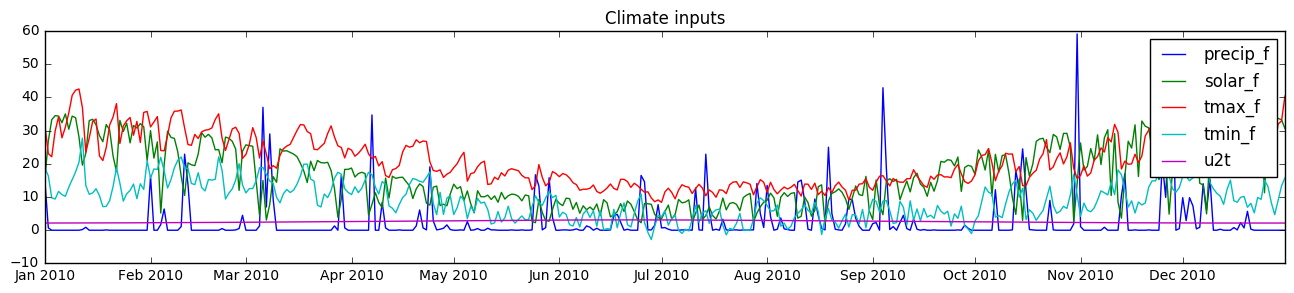

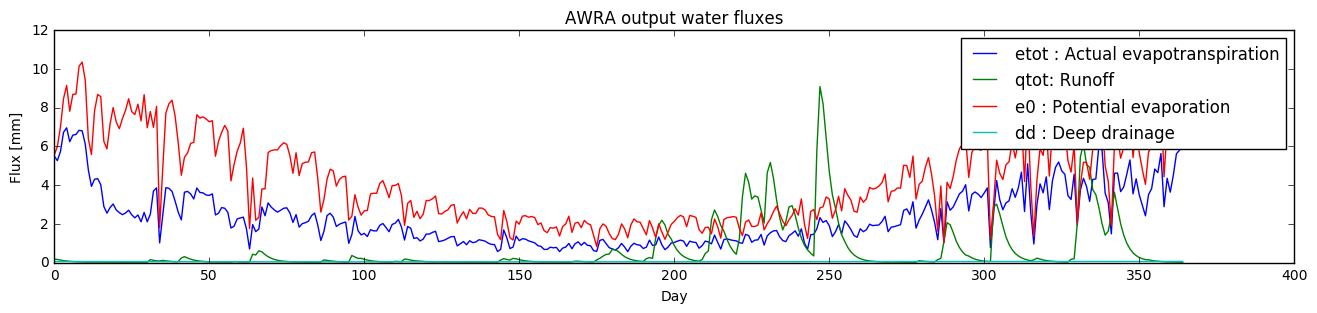

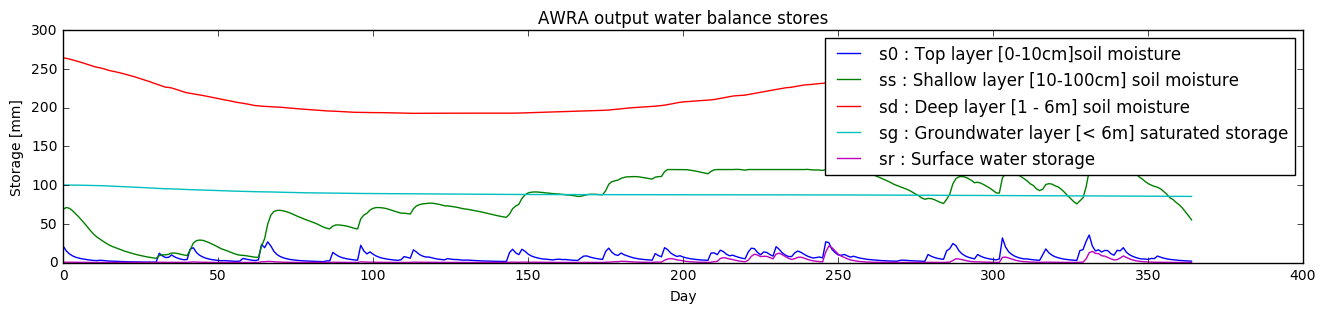

In [3]:
# NOTE:
# Dont try and understand this first up, just look at the broad steps listed
# Subsequent training notebooks will go through this in detail.
# Run cell to see AWRA inputs for a given location (extent) and time period (period)

##########################################################################
#   1. Load awral model module and instantiate the model by calling AWRALModel
from awrams.models import awral
awralmod = awral.model.AWRALModel()

###########################################################################
#   2.  Define extent and period
# my_extent and my_period will be passed to our simulation engine
## Define an  extent my_extent - the area over which the simulation is run
from awrams.utils import extents
# start with the default extent, then use methods associated with a defined extent to set a particular location
DefExt = extents.get_default_extent()
## E.g. Bendigo (VIC) (-36.75, 144.30)  for the period July 2010 - Jul 2011
my_extent  = DefExt.factory.get_by_cell_coords(-36.75,144.30)
print('my_extent=',my_extent)
# Define a period my_period for running the simulation
from awrams.utils import datetools as dt
my_period = dt.dates('jan 2010 - dec 2010') 
print('my_period=',my_period)

###########################################################################
#   3. Define model configuration (nodegraph)
## Define the location of the climate (forcing) inputs for selected period
# This configuration information is passed into AWRA using a 'nodegraph' mapping contained in input_map
input_map = awralmod.get_default_mapping()
print('Location of climate inputs:')
print('Path to Tmin data before change...')
print('tmin_f',input_map['tmin_f'])
#
# Create a function change_path_to_forcing() to change from the default paths to  
def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes
    from os.path import join
    from os import getcwd

    # location of test simulation data from github
    #data_path = '../../test_data/simulation/'
    #FORCING = {
    #    'tmin': ('temp_min*.nc','temp_min_day',data_path),
    #    'tmax': ('temp_max*.nc','temp_max_day',data_path),
    #    'precip': ('rain_day*.nc','rain_day',data_path),
    #    'solar': ('solar*.nc','solar_exposure_day',data_path) #,
    #}
    
    # location of registered user data in the Training folder
    data_path = '../test_data/climate/BOM_climate/'
    FORCING = {
        'tmin': ('temp_min*.nc','temp_min_day',data_path + 'temp_min_day/'),
        'tmax': ('temp_max*.nc','temp_max_day',data_path + 'temp_max_day/'),
        'precip': ('rain_day*.nc','rain_day',data_path + 'rain_day/'),
        'solar': ('solar*.nc','solar_exposure_day',data_path + 'solar_exposure_day/') #,
    }     
    
    for k,v in FORCING.items():
        imap[k+'_f'] = nodes.forcing_from_ncfiles(v[2],v[0],v[1])

change_path_to_forcing(input_map)
print('Path to Tmin data after change...')
print('tmin_f',input_map['tmin_f'])

# add some extra outputs via the output_mapping
output_map = awralmod.get_output_mapping()
awralmod.OUTPUTS['OUTPUTS_CELL'].append('eg')
awralmod.OUTPUTS['OUTPUTS_CELL'].append('y')
awralmod.OUTPUTS['OUTPUTS_CELL'].append('qg')
awralmod.OUTPUTS['OUTPUTS_CELL'].append('qr')
awralmod.OUTPUTS['OUTPUTS_CELL'].append('qif')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('ei')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('et')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('es')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('fsat')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('fegt')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('us')
awralmod.OUTPUTS['OUTPUTS_HRU'].append('ud')


###########################################################################
# 4. Run ondemand simulation to get AWRA-L inputs i
## use the ondemand simulation engine
from awrams.simulation import ondemand

# get and instance of the model runner engine - passing in the model (awral and input_map defined earlier)
runner = ondemand.OnDemandSimulator(awralmod,input_map) #,omapping=omap.mapping)

# Call the run fun function (within the OnDemandSimulator) over the defined period and extent
r,i = runner.run(period=my_period,extent=my_extent,return_inputs=True)

# r contains the run outputs
# i is the inputs returned - provided as return_inputs=True
print('Example AWRA inputs at location...')
print('kssat',i['kssat'])
print('pair',i['pair'])


###########################################################################
# 5. Transfer i to arrays for future use and plot (timseries/hypsometric curves) to understand
# 
import pandas as pd

# Transfer inputs
# transfer climate inputs contained in i
forcing = ('tmin_f','tmax_f','solar_f','precip_f', 'u2t')
clm = {k:i[k].reshape(-1) for k in forcing}
df_clm = pd.DataFrame(clm,index=my_period)
# transfer grid inputs to an array for use later
grid_names=['f_tree_grid','hveg_dr_grid','k0sat_v5_grid','k_gw_grid','kdsat_v5_grid','kssat_v5_grid','lai_max_grid','meanpet_grid','ne_grid','pref_grid','s0fracawc_grid','slope_grid','ssfracawc_grid','windspeed_grid']
# get the values of the grids for your location/extent through i
grids = {k:i[k][0] for k in grid_names}
df_spgrids = pd.Series(grids)
## Get calibrated parameters
import json
import pandas as pd
model_paramset = json.load(open(awral.settings.DEFAULT_PARAMETER_FILE,'r'))
df_params = pd.DataFrame(model_paramset)
## Get hypsometric percentiles
# these are essentially DEMS within the grid cell
# this give the height of the cell when ranked within a DEM
import numpy as np
df_hypso = pd.DataFrame([i['hypsperc'],i['height_grid']], dtype=np.float32).T
df_hypso.columns=["Percent_saturated", "Value"]

# Plot inputs/outputs as timeseries
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (16,3))
plt.plot(df_clm)
plt.title('Climate inputs')
plt.legend(df_clm.columns)

plt.figure(figsize = (16,3))
plt.plot(r['etot'],label='etot : Actual evapotranspiration')
plt.plot(r['qtot'],label='qtot: Runoff')
plt.plot(r['e0'],label='e0 : Potential evaporation')
plt.plot(r['dd'],label='dd : Deep drainage')
plt.title('AWRA output water fluxes')
plt.xlabel('Day')
plt.ylabel('Flux [mm]')
plt.legend()
plt.figure(figsize = (16,3))

plt.plot(r['s0'],label='s0 : Top layer [0-10cm]soil moisture')
plt.plot(r['ss'],label='ss : Shallow layer [10-100cm] soil moisture')
plt.plot(r['sd'],label='sd : Deep layer [1 - 6m] soil moisture')
plt.plot(r['sg'],label='sg : Groundwater layer [< 6m] saturated storage')
plt.plot(r['sr'],label='sr : Surface water storage')
plt.xlabel('Day')
plt.ylabel('Storage [mm]')
plt.title('AWRA output water balance stores')
plt.legend()

print('AWRA output variable names r.keys():')
r.keys()


In [4]:
# view inputs i
i.keys()

dict_keys([0.5, 1.0, 2.0, 'fhru_hrusr', 'f_tree_grid', 'k_gw_scale', 'hveg_hrudr', 'solar_f', 'ud0_hrudr', 'laimax_hrudr', 'init_s0_hrusr', 'vc_hrudr', 'pair', 'us0_hrudr', 'wdlimu_hrusr', 'hveg_dr_grid', 'pt', 's0max_scale', 'lairef_hrusr', 'hypsperc', 'ne', 'lairef_hrudr', 'w0lime_hrusr', 's_sls_hrusr', 'sdmax_scale', 'wslimu_hrusr', 'init_sd_hrudr', 'tsenc_hrusr', 'k_gw', 'k_rout_scale', 'kssat', 'rgt', 'vc_hrusr', 'wslimu_hrudr', 0.1, 'tmax', 'height', 'radcskyt', 'fsoilemax_hrusr', 'slope', 'k_rout_int', 'init_mleaf_hrusr', 'tmin', 'init_s0_hrudr', 'windspeed_grid', 'alb_dry_hrudr', 'ssmax_scale', 'rd_hrusr', 'cgsmax_hrusr', 100.0, 'k0sat', 'ne_scale', 's0fracawc_grid', 'cgsmax_hrudr', 'sdmax', 'sla_hrudr', 'kssat_scale', 'u2t', 'ssfracawc_grid', 'kr_coeff', 'kssat_v5_grid', 'init_ss_hrudr', 'tmax_f', 'rd_hrudr', 900.0, 'init_sr', 'tgrow_hrusr', 'sla_hrusr', 5000.0, 'avpt', 'alb_wet_hrudr', 'wdlimu_hrudr', 'fday', 'tat', 'init_ss_hrusr', 'height_grid', 'init_sg', 'w0lime_hrudr', '

In [5]:
# view input parameter 'ssmax' as part of i list
i['ssmax']

array([ 119.94343567], dtype=float32)

# 2. Step-by-step overview of AWRA-L processes


## The cells below break the AWRA-L calculations into separate functions for understanding purposes

The broad steps include:

1. Pre-calculate and convert constants for use in the model
2. Initialise  models states
3. Loop over Timesteps [***ATTENTION: This daily looping is not undertaken here*** Demo only]

    - A. Calculate saturated fraction of cell/catchment for a given groundwater storage (Sg) [a single store - no HRUs]
    - B. Calculate potential evaporation (E0) according to Energy balance [***for each HRU***]
    - C. Calculate actual ET based on E0, water storage and vegetation state [***for each HRU***]
    - D. Calculate Water balance and flows [***for each HRU***]
    - E. Calculate Vegetation growth and senescence [***for each HRU***]
    - F. Get cell values of variables  weighting shallow and deep rooted components depending on fraction of each 
    
   End loop



Equations and sections quoted are from the: 
  - **BoM model description report**: Frost, A. J., Ramchurn, A., and Smith, A. 2016b. The Bureau’s Operational AWRA Landscape (AWRA-L) Model. Bureau of Meteorology Technical Report.
http://www.bom.gov.au/water/landscape/static/publications/Frost__Model_Description_Report.pdf

Further details of the model development and derivation can ve found in:

 - **Original v0.5 model parameterisation report** : Van Dijk, A. 2010. The Australian Water Resources Assessment System. Landscape Model (version 0.5). Technical Report 3. CSIRO. Australia. http://www.bom.gov.au/water/landscape/static/publications/Van_Dijk_AWRA05_TechReport3.pdf
 
 - **CSIRO AWRA-L v5.0 model parameterisation**: Viney, N, Vaze J, Crosbie R, Wang B, Dawes W and Frost A (2015) AWRA-L v5.0: technical description of model algorithms and inputs. CSIRO, Australia. http://www.bom.gov.au/water/landscape/static/publications/Viney_et_al_2015_AWRA_L_5.0_model_description.pdf

     

## 2.1. Pre-calculate and convert constants for use in the model
   - Constant do not change on a timestep basis so are calculated once for each location within the extent
   - Some are calibrated, set or known values: eg. df_hypso, df_params, StefBolz
   - Some are read in from spatial grids: eg. df_spgrids

In [6]:
## 1. Pre-calculate and convert constants for use in the model

# Hypsometric curves - see section 2.1.3 
# Required for determination of fraction saturated (fsat) and fraction accessible for transpiration (fEgt)
height = df_hypso['Value']; 

# Effective porosity (ne) - required to translate hypsometric curve values to equivalent Sg values
ne_scale=df_params[df_params['MemberName']=='ne_scale']['Value'].values 
ne = df_spgrids['ne_grid']*ne_scale
# Sgtemp: equivalent height in terms of Sg: Temporary set of groundwater storage levels equivalent to lookup table of heights [mm]
Sgtemp  = height * 1000.0 * ne

# Vegetation photosynthetic capacity index (per unit canopy cover) - a parameter
Vc = df_params[df_params['MemberName'].str.contains('Vc_')]['Value'].values  
alb_veg   = 0.452 * Vc    #  vegetation albedo (Eqn. 41)
StefBolz  = 5.67e-8       #  Stefan-Boltzmann constant required for Upward longwave radiation (Section 3.2.2)

# Vegetation height of  vegetation - deep rooted values read in from a grid, shallow assumed 0.5m
hveg = np.array([df_spgrids['hveg_dr_grid'],df_params[df_params['MemberName'].str.contains('hveg_hruSR')]['Value'].values[0]])
# Calculate components of aerodynamic conductance (Eqn 56, Sec 3.3.4 Root Water Uptake)
fh        = np.log(813. / hveg - 5.45)
ku2      = 0.305 / (fh * (fh + 2.3))

# cGsmax parameter: Coefficient relating vegetation photosynthetic capacity to maximum stomatal conductance 
# Used in calculating Canopy (surface) conductance gs and maximum possible transpiration
# See section 3.3.4 Root water uptake Eqn 57
cGsmax =  df_params[df_params['MemberName'].str.contains('cGsmax_')]['Value'].values
Gsmax       = cGsmax * Vc

# Leaf Area Index (LAI) parameters used in vegetation model (Chapter 4)
# LAImax: Maximum leaf area index [-]: Spatial grid parameter 
LAImax = df_spgrids['lai_max_grid']
# LAIref: reference leaf are index [-]
LAIref = df_params[df_params['MemberName'].str.contains('LAIref_')]['Value'].values 
# fvmax: Maximum achievable canopy cover (Eqn 65)
fvmax = 1. - np.exp(-max(LAImax,0.0027777778450399637)/LAIref)

## Parameters used within the timeseries loop
# SLA: specific leaf area [m2 kg–1] (the ratio of leaf area to dry mass)
# Used for conversion of biomass into LAI (Eqn 63, Section 4)

SLA = df_params[df_params['MemberName'].str.contains('SLA_')]['Value'].values
# Various calibrated scaling parameters and mapped values of maximum soil moisture storage
# defines drainage and storage characteristics - see section 2.1.2
# s0max_scale: Scaling parameter for maximum storage of the surface (0-10cm) soil layer [-] 
s0max_scale = df_params[df_params['MemberName'].str.contains('S0max_scale')]['Value'].values 
# ssmax_scale: Scaling parameter for maximum storage of the shallow (10-100cm) soil layer [-] : Eqn 15
ssmax_scale = df_params[df_params['MemberName'].str.contains('Ssmax_scale')]['Value'].values
# sdmax_scale: Scaling parameter for maximum storage of the deep (100-600cm) soil layer [-] : Eqn 16
sdmax_scale = df_params[df_params['MemberName'].str.contains('Sdmax_scale')]['Value'].values
# S0max: maximum storage of the surface (0-10cm) soil layer [mm] : Eqn 14
S0max = 100*df_spgrids['s0fracawc_grid']*s0max_scale
# Ssmax: maximum storage of the shallow (10-100cm) soil layer [mm] : Eqn 15
Ssmax = 900*df_spgrids['ssfracawc_grid']*ssmax_scale
# Sdmax: maximum storage of the deep (100-600cm) soil layer [mm] : Eqn 16
Sdmax = 5000/900*Ssmax*sdmax_scale

print('Example constants:')
print('ne =',ne,'Effective porosity (ne)')
print('Vc =',Vc,'Vegetation photosynthetic capacity index (per unit canopy cover)') 
print('alb_veg =',alb_veg,' Vegetation albedo')
print('hveg =',hveg,'Vegetation height of deep rooted vegetation/trees (hveg)')
print('LAImax =',LAImax)
print('LAIref (shallow, deep rooted HRUs)=',LAIref)
print('fvmax (shallow, deep rooted HRUs)=',fvmax)
print('SLA (shallow, deep rooted HRUs)=',SLA,'specific leaf area [m2 kg–1] (the ratio of leaf area to dry mass)')
print('S0max=',S0max, 'maximum storage of the surface (0-10cm) soil layer [mm]')
print('Ssmax=',Ssmax,'maximum storage of the shallow (10-100cm) soil layer [mm]')
print('Sdmax=',Sdmax,'maximum storage of the deep (100-600cm) soil layer [mm]')

Example constants:
ne = [ 0.01324538] Effective porosity (ne)
Vc = [ 0.35  0.65] Vegetation photosynthetic capacity index (per unit canopy cover)
alb_veg = [ 0.1582  0.2938]  Vegetation albedo
hveg = [ 0.5  0.5] Vegetation height of deep rooted vegetation/trees (hveg)
LAImax = 0.628000020981
LAIref (shallow, deep rooted HRUs)= [ 2.5  1.4]
fvmax (shallow, deep rooted HRUs)= [ 0.22213322  0.36146031]
SLA (shallow, deep rooted HRUs)= [  3.  10.] specific leaf area [m2 kg–1] (the ratio of leaf area to dry mass)
S0max= [ 41.27615476] maximum storage of the surface (0-10cm) soil layer [mm]
Ssmax= [ 119.94343389] maximum storage of the shallow (10-100cm) soil layer [mm]
Sdmax= [ 529.83147133] maximum storage of the deep (100-600cm) soil layer [mm]


## 2.2. Initialisation of models states

1. Model water balance stores:
  - required for both HRUs (shallow and deep) - currently set the same
      - **S0** - upper soil layer (0-10cm) storage (mm) 
      - **Ss** - shallow soil layer (10-100cm) storage (mm) for both HRUs (shallow and deep) 
      - **Sd** - deep soil layer(100-600cm) storage (mm) for both HRUs (shallow and deep) 
  - a single value for groundwater and surface water stores (not different for HRUs)
      - **Sg** - groundwater store storage (mm)  
      - **Sr** - Surface runoff store
2. Vegetation biomass (**Mleaf**) 


In [7]:
# Function defining initial soil water stores (S0, Ss, Sd, Sg, Sr)) : default set to 0   
def init_stores(S0 = S0max[0]/2, Ss = Ssmax[0]/2, Sd = Sdmax[0]/2, Sg = 100, #0.01 * meanP / K_gw, 
                Sr = 0, SLA = SLA):
    import numpy as np    
    Mleaf = (SLA*0.0 + 2.0) / SLA
    c_hru = 2
      
    return np.repeat(S0,c_hru), np.repeat(Ss,c_hru), np.repeat(Sd,c_hru), Sg, Sr, Mleaf

S0, Ss, Sd, Sg, Sr, Mleaf = init_stores()

print('Initial states=')
print('S0=',S0,'mm : upper soil layer (0-10cm) storage  [shallow, deep rooted]')
print('Ss=',Ss,'mm : shallow soil layer (10-100cm) storage  [shallow, deep rooted]')
print('Sd=',Sd,'mm : deep soil layer (100-600cmcm) storage (mm) [shallow, deep rooted]')
print('Sg=',Sg,'mm : groundwater store storage')
print('Sr=',Sr,'mm : surface water store storage')
print('Mleaf=',Mleaf)

Initial states=
S0= [ 20.63807738  20.63807738] mm : upper soil layer (0-10cm) storage  [shallow, deep rooted]
Ss= [ 59.97171694  59.97171694] mm : shallow soil layer (10-100cm) storage  [shallow, deep rooted]
Sd= [ 264.91573566  264.91573566] mm : deep soil layer (100-600cmcm) storage (mm) [shallow, deep rooted]
Sg= 100 mm : groundwater store storage
Sr= 0 mm : surface water store storage
Mleaf= [ 0.66666667  0.2       ]


## 2.3  Timestep loop components

### 2.3.A. Calculate fraction saturated (fsat) and fraction plant access to groundwater (fEgt) from Groundwater storage (Sg) and Hypsometric curves

####    -***fsat***: fraction saturated influences overland runoff and proportion of landscape available for evaporation.
####    -***fEgt***: ffraction plant access to groundwater influnces amount of transpiration from saturated store.

#### See report section 2.1.3 Groundwater storage and fluxes 

   - depth = 0 for at lowest point within the gridcell
   - depth = RD at root depths for each HRU
![title](HypsometricConceptualDiagram.PNG)

****ATTENTION: a particular single value of fsat and fEgt is used for subsequent calculations for all timesteps in this demonstration
****ATTENTION: This is a time varying variable when undertaken within the timestep loop of AWRA-L


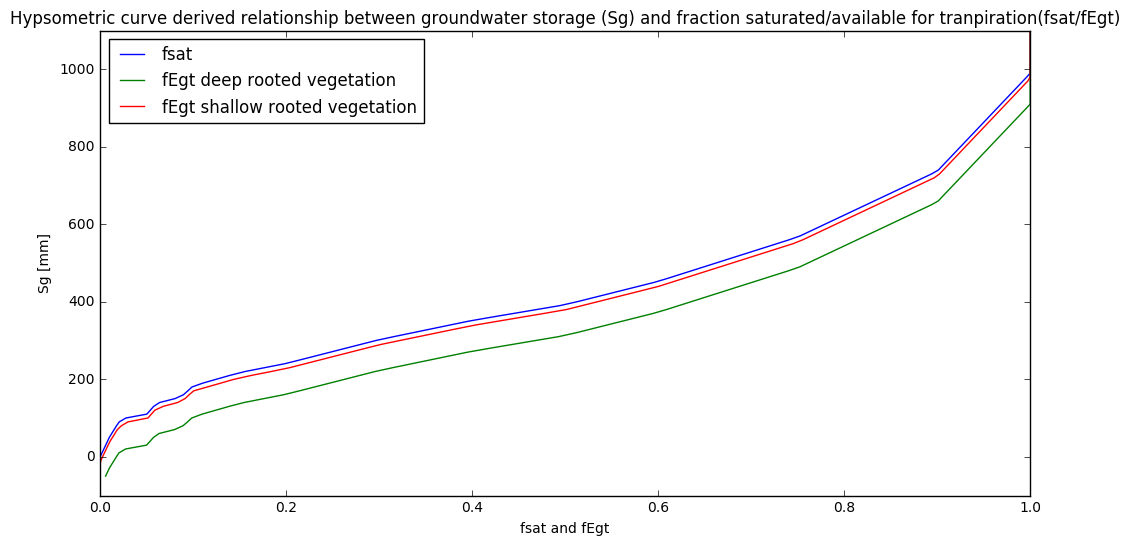

In [8]:
## Calculate fraction saturated (fsat) and fraction plant access to groundwater (fEgt) from Sg and Hypsometric curves
#       - fsat: fraction saturated influences overland runoff and proportion of landscape available for evaporation.
#       - fEgt: fraction plant access to groundwater influnces amount of transpiration from saturated store.
#
#   ATTENTION: a particular single value of fsat and fEgt is used for subsequent calculations for all timesteps in this demonstration
#   ATTENTION: This is a time varying variable when undertaken within the timestep loop of AWRA-L

# Inputs
# Sg : groundwater storage state [mm]
# set of Hysometric curve heights  - see section 2.1.3 
height = df_hypso['Value'];
# set of Hysometric curve fsat values for each height value
Hypsfsat = df_hypso['Percent_saturated']
# Effective porosity (ne) - required to translate hypsometric curve values to equivalent Sg values
ne_scale=df_params[df_params['MemberName']=='ne_scale']['Value'].values 
ne = df_spgrids['ne_grid']*ne_scale

# Root Depth parameter (RD) for shallow and deep rooted vegetation (currently set to 1m, 6m respectively: same depth as soil stores)
RD = df_params[df_params['MemberName'].str.contains('RD_')]['Value'].values
EffRD=RD*1000*ne # effective root depth
# Sgtemp: equivalent height in terms of Sg: Temporary set of groundwater storage levels equivalent to lookup table of heights [mm]
Sgtemp  = height * 1000.0 * ne

def calc_fsat(Sg, Sgtemp, Hypsfsat, offset=0.0):
# calc_fsat: function for calculation of fraction saturated
    #  Inputs:
    #   Sg       : groundwater storage [mm]
    #   Sgtemp   : Temporary set of groundwater storage levels equivalent to lookup table of heights [mm]
    #   Hypsfsat : set of Hysometric curve fsat values for each height value
    #   offset   : effective root depth offset (in terms of Sg storage) for shallow and deep rooted vegetation when used in transpiration (0 if Eg=evap)


    npctiles = len(height) # number of percentiles

    #   Determine fsat
    #   for 'Hypsfsat' percentiles and 'height' for current pixel  
    #   Where Sg is 0
    sgmin = Sgtemp[0] + offset;
    sg_eff = sgmin+Sg
    npctiles = 20
    if(Sg+offset<=0.0): 
    #   Where level is below minimum level      
        fsat = 0
    elif (sg_eff>=Sgtemp[npctiles-1]):  
    #   Where maximum elevation is exceeded by Sg  
        fsat = 1.0            
    else:
    #   Gets indices for ranked height percentile vals
    #   for linear interpolation for fsat from hypso. curve            
        id0 = -1;
        for  i in range(npctiles):
            if (sg_eff >= Sgtemp[i]):
                id0=id0+1
            else:
                break;
        id1 = id0+1;
        # could have used the following instead of the above for loop - same as C code here
        # id1=np.argmin(sg_eff>=Sgtemp)
        # id0=id1-1
        srange = Sgtemp[id1]-Sgtemp[id0];
        hdiff = Hypsfsat[id1]-Hypsfsat[id0];
        fsat=Hypsfsat[id0]+hdiff*(sg_eff-Sgtemp[id0])/srange


    return np.array(fsat)

# Show the relationship between storage and fsat and fEgt
# Evaluate function over Sg =[-100,30000]
# Sg can go below zero through deep rooted uptake
fsat=[];fEgt={}
Sgs=range(-50,1150,10)
for Sg  in Sgs:
    fsat.append( calc_fsat(np.array(Sg), Sgtemp, Hypsfsat, offset=0.))
for hru in [0,1]:
    fEgt[hru]=[]
    for Sg  in Sgs:
        fEgt[hru].append( calc_fsat(Sg, Sgtemp, Hypsfsat, offset=EffRD[hru]) )


plt.figure(figsize = (12,6))
plt.plot(fsat,Sgs,label='fsat')
plt.plot(fEgt[0],Sgs,label='fEgt deep rooted vegetation')
plt.plot(fEgt[1],Sgs,label='fEgt shallow rooted vegetation')
plt.title('Hypsometric curve derived relationship between groundwater storage (Sg) and fraction saturated/available for tranpiration(fsat/fEgt)')
plt.ylabel('Sg [mm]')
plt.xlabel('fsat and fEgt')
plt.ylim([-100,1100])
plt.legend(loc=2)

print('****ATTENTION: a particular single value of fsat and fEgt is used for subsequent calculations for all timesteps in this demonstration')
print('****ATTENTION: This is a time varying variable when undertaken within the timestep loop of AWRA-L')
Sg=100
fsat=calc_fsat(Sg, Sgtemp, Hypsfsat, offset=0.)
fEgt=[]
for hru in [0,1]:
    fEgt.append( calc_fsat(Sg, Sgtemp, Hypsfsat, offset=EffRD[hru]) )      

### 2.3.B. Calculate potential evaporation (E0) according to Energy balance [for each HRU]
####  ***Calculate clear sky radiation***

Feeds into:
   - downward longwave radiation (sec 3.2.3) calculation 
   - energy balance and potential evaporation (E0)
   - overall Actual ET as E0 defines maximum level
   
Depends on:
   - latitude (latitude) and time of year (period) for solar angle
   - atmospheric transmissivity for a clear sky (g0_frac)

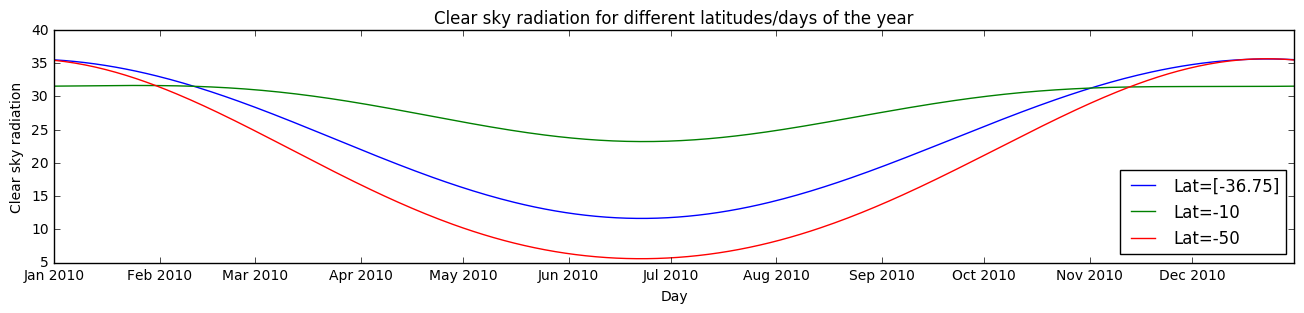

In [9]:
## Calculate clear sky radiation (RadClearSky)
#  Feeds into:
#      - downward longwave radiation (sec 3.2.3) calculation 
#      - energy balance and potential evaporation (E0)
#      - overall Actual ET as E0 defines maximum level
# Depends on:
#      - latitude (latitude) and time of year (period) for solar angle
#       - atmospheric transmissivity for a clear sky (g0_frac)
#  also see Appendix A: : Downward longwave radiation derivation

period = my_period
# latitude
latitude = my_extent.latitudes.to_degrees()
# atmospheric transmissivity (g0_frac) AWRA-L uses 0.8  Eqn. 71 
g0_frac = 0.8 #

def calc_clrskyrad(g0_frac, latitude, period):
    # Function for calculation of clear sky radiation (see Appendix B)
    # Inputs:
    #    g0_frac: atmospheric transmissivity 
    #    latitude and 
    #    period: dates for calcualtion of time of year for angle of sun    
    
    import numpy as np
    import math
    
    # 1. Calculate global extra-terrestrial radiation
    
    # create Julian day array
    period_juldays = np.array([(theday.strftime("%j")) for theday in my_period]).astype(np.float32)
    
    # The following values are calculated  prior to entering the core model code in:  
    # ../../models/awrams/models/awral/solar.py
    # q0: Day angle [radians] : Eqn. 77
    q0 = 2*math.pi*(period_juldays-1)/365
    # ecc: Eccentricity correction factor of the Earth’s orbit (around the sun) [-]  Eq 73
    ecc = 1+0.033*np.cos(q0) 
    # delta: solar declination [radians]: Eqn. 76
    delta = 0.006918 - 0.399912 * np.cos(q0) + 0.070257 * np.sin(q0) -0.006758 * np.cos(2 * q0) + 0.000907 \
            * np.sin(2 * q0) -0.002697 * np.cos(3 * q0) + 0.00148 * np.sin(3 * q0)
    # phi: latitude [radians]
    phi = latitude*math.pi/180
    # omega: sunset hour [radians]: Eqn 75
    omega = np.arccos(-1.0 *np.tan(phi)*np.tan(delta))
    
    # ge_MJ: Extraterrestrial radiation [MJ/m2/day] : Eqn 72
    # (solar constant Isc [4921 kJ/m2/h] * 24h)= 118104 kJ/m2/day= 118.1 MJ/m2/day
    ge_MJ = 118.1 / math.pi * ecc * (omega * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(omega))  # in MJm-2d-1, diingman ref uses 117.8
  
    
    # g0_frac: AWRA-L uses 0.8 (Roderick, 1999) Eqn 71
    #2. Apply transmissivity fraction for clear sky 
    RadClearSky = ge_MJ*g0_frac
    return RadClearSky


# Calculate the radiation for clear sky for the entire timeseries - also at lats -10 and -50 for comparrison
RadClearSky   = calc_clrskyrad(g0_frac = g0_frac, latitude = my_extent.latitudes.to_degrees() , period = my_period)
RadClearSky10 = calc_clrskyrad(g0_frac = g0_frac, latitude = -10. , period = my_period)
RadClearSky50 = calc_clrskyrad(g0_frac = g0_frac, latitude = -50. , period = my_period)
# Plot the outputs
RadClearSky=pd.DataFrame(RadClearSky,index=my_period)
RadClearSky10=pd.DataFrame(RadClearSky10,index=my_period)
RadClearSky50=pd.DataFrame(RadClearSky50,index=my_period)
plt.figure(figsize = (16,3))
plt.plot(RadClearSky,label='Lat='+str(my_extent.latitudes.to_degrees()))
plt.plot(RadClearSky10,label='Lat=-10')
plt.plot(RadClearSky50,label='Lat=-50')
plt.legend(loc=4)
plt.xlabel('Day')
plt.ylabel('Clear sky radiation')
plt.title('Clear sky radiation for different latitudes/days of the year')


####  Potential evaporation (E0)

  - A. Calculate net Short Wave Radiation balance (RSn)
  - B. Calculate net Long Wave Radiation balance (RLn)
  - C. Calculate Penman potential evaporation (E0) from a water surface according to absorbed energy

See Model description report:
  - section 3.1 Potential evaporation (E0)
  - Appendix B: Downward longwave radiation derivation


Shortwave radiation balance both HRUs [shallow/deep rooted]
fveg=      [ 0.55067104  0.76034896] Fractional canopy cover [-]
Rgeff=     15.8100004196 Downwelling shortwave (solar) radiation [MJ m–2 d–1]
Vc=        [ 0.35  0.65] Vegetation photosynthetic capacity index
alb_dry=   [ 0.26  0.26] Dry soil albedo [-]
alb_wet=   [ 0.16  0.16] Wet soil albedo [-]
w0ref_alb= [ 0.3  0.3] Reference value of w0....
w0=        [ 0.5  0.5] Relative soil moisture content of the top soil layer


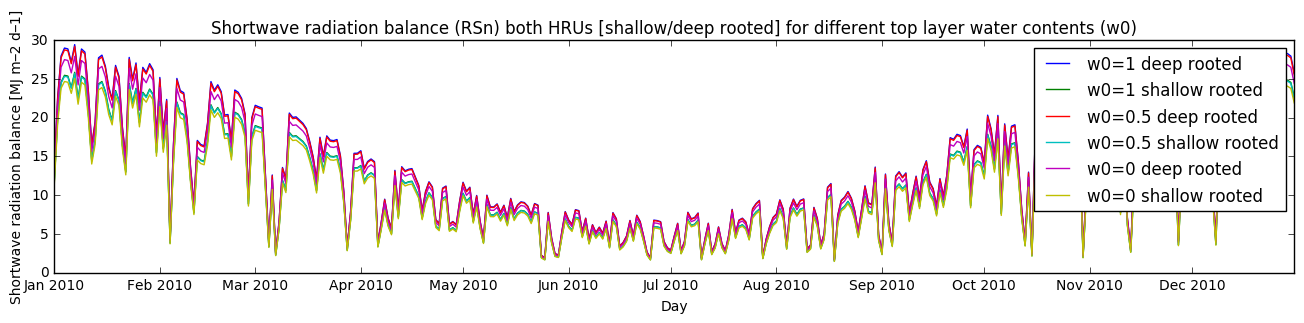

In [10]:
## Potential evaporation (E0)
#     a. Calculate net Short Wave Radiation balance (RSn)
#     b. Calculate net Long Wave Radiation balance (RLn)
#     c. Calculate Penman potential evaporation (E0) from a water surface according to absorbed energy
#############################################

#
# 5a. calculate net Short Wave Radiation balance (RSn)

# Get Albedo parameters
w0ref_alb  = df_params[df_params['MemberName'].str.contains('w0ref_alb_')]['Value'].values
alb_dry = df_params[df_params['MemberName'].str.contains('alb_dry')]['Value'].values
alb_wet = df_params[df_params['MemberName'].str.contains('alb_wet')]['Value'].values

# Incoming shortwave radiation (Rgeff)
Rgeff       = df_clm['solar_f']  #Wm-2
# Relative soil moisture content of the top soil layer [-] Eqn. 20 
# effects albedo dynamically
w0 = S0 /S0max   # S0=Water storage in the surface soil layer [mm]   S0max=Maximum storage of the surface soil layer (mm)

# Leaf area Index (LAI) Eq 63 - required for calculation of fveg from Mleaf
LAI   = SLA * Mleaf   #  Mleaf=Leaf biomass [kg m–2]   SLA=Specific leaf area [m2 kg–1]
# Fraction canopy cover (fveg)  Eq 64
fveg  = 1. - np.exp(-LAI / LAIref)   # LAIref=Reference leaf area index (at which fv = 0.63)

def calc_netSW(fveg, Rgeff, Vc, alb_dry, alb_wet, w0ref_alb, w0):  
# Shortwave radiation balance 
    # Inputs:
    #       fveg      : Fractional canopy cover [-]
    #       Rgeff     : Daily downwelling shortwave (solar) radiation [MJ m–2 d–1]
    #       Vc        : Vegetation photosynthetic capacity index per unit canopy cover [-]
    #       alb_dry   : Dry soil albedo [-]
    #       alb_wet   : Wet soil albedo [-]
    #       w0ref_alb : Reference value of w0 that determines the rate of albedo decrease with wetness
    #       w0        : Relative soil moisture content of the top soil layer [-] Eqn. 20
    
    # Vegetation albedo (alb_veg) - Eqn. 41
    alb_veg   = 0.452 * Vc
    # Soil albedo (alb_soil) [-] - Eqn. 41...
    alb_soil  = alb_wet + (alb_dry - alb_wet) * np.exp(-w0 / w0ref_alb)
    # Fraction soil cover (fsoil) [-] Eqn. 40
    fsoil     = 1 - fveg
    # land surface albedo (alb) [-] Eqn. 38
    alb       = fveg * alb_veg + fsoil * alb_soil
    
    # Shortwave radiation balance (RSn) [MJ m–2 d–1] Eqn 38
    # RSn=Downward - Upward= Rgeff    - alb* Rgeff 
    RSn       = (1.0 - alb) * Rgeff
    
    return RSn

# Calculate Shortwave radiation balance for all timesteps over both HRUs 
# Note fveg nad w0 change dynamically on a timestep basis - not constants as here
print('Shortwave radiation balance both HRUs [shallow/deep rooted]')
RSn={};RSnWet={};RSnDry={}
for hru in [0,1]:
    RSn[hru]=calc_netSW(fveg[hru], Rgeff, Vc[hru], alb_dry[hru], alb_wet[hru], w0ref_alb[hru], w0[hru])
    RSnWet[hru]=calc_netSW(fveg[hru], Rgeff, Vc[hru], alb_dry[hru], alb_wet[hru], w0ref_alb[hru], 1.0)
    RSnDry[hru]=calc_netSW(fveg[hru], Rgeff, Vc[hru], alb_dry[hru], alb_wet[hru], w0ref_alb[hru], 0.0)    

# plot it
plt.figure(figsize = (16,3))
plt.plot(RSnWet[0],label='w0=1 deep rooted')
plt.plot(RSnWet[1],label='w0=1 shallow rooted')
plt.plot(RSn[0],label='w0='+str(w0[0])+' deep rooted')
plt.plot(RSn[1],label='w0='+str(w0[1])+' shallow rooted')
plt.plot(RSnDry[0],label='w0=0 deep rooted')
plt.plot(RSnDry[1],label='w0=0 shallow rooted')




plt.xlabel('Day')
plt.ylabel('Shortwave radiation balance [MJ m–2 d–1]')
plt.title('Shortwave radiation balance (RSn) both HRUs [shallow/deep rooted] for different top layer water contents (w0)')
plt.legend()
print('fveg=     ',fveg,'Fractional canopy cover [-]')
print('Rgeff=    ',Rgeff[0],'Downwelling shortwave (solar) radiation [MJ m–2 d–1]')
print('Vc=       ',Vc,'Vegetation photosynthetic capacity index')
print('alb_dry=  ',alb_dry,'Dry soil albedo [-]')
print('alb_wet=  ',alb_wet,'Wet soil albedo [-]')
print('w0ref_alb=',w0ref_alb,'Reference value of w0....')
print('w0=       ',w0,'Relative soil moisture content of the top soil layer')



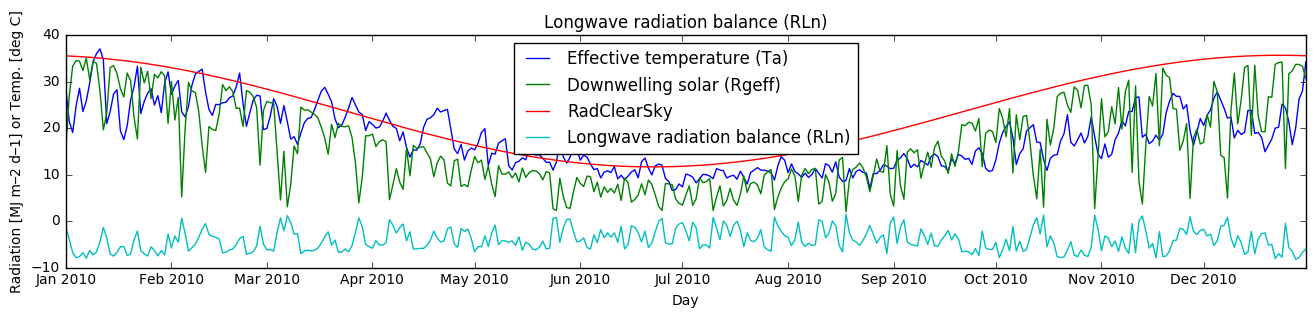

In [11]:
#
# b. Calculate net Long Wave Radiation balance (RLn)


# Get climate inputs
# Minimum and Maximum Daily temperature (Tmin, Tmax)
# Ensure max>min see ../../models/awrams/models/awral/description.py
# Calculate Effective temperature (Ta) - see Eqn 33
tmin= np.minimum(df_clm['tmin_f'],df_clm['tmax_f']) #'tmin': nodes.transform(np.minimum,['tmin_f','tmax_f'])
tmax= np.maximum(df_clm['tmin_f'],df_clm['tmax_f']) #'tmax': nodes.transform(np.maximum,['tmin_f','tmax_f'])
Ta = (tmax*0.75 + tmin*0.25)   # mapping['tat'] = nodes.mix('tmin','tmax',0.75) in /description.py

# Actual vapour pressure [Pa] (pe) - Eqn 36 - Uses Tmin (not average) on assumption air is saturated at night when temp at min.
# ######### Calculated in transforms.py ####### prior to model timestep 
# this calculation is undertaken prior to entering the AWRA code in  ../../models/awrams/models/awral/transforms.py
pe  = 610.8 * np.exp(17.27 * tmin / (237.3 + tmin))  # Pa


def calc_netLW(Ta, pe, Rgeff, RadClearSky, emissivity=1):
    # Long Wave Radiation balance (RLn) 
    # section 3.2.2 and 3.2.3 and Appendix B
    #
    # Inputs:
    #    Ta          = Effective temperature [deg. C]
    #    pe          = Actual vapour pressure [Pa] 
    #    Rgeff       = Downwelling shortwave (solar) radiation [MJ m–2 d–1]
    #    RadClearSky = Expected downwelling shortwave radiation on a cloudless day [MJ m–2 d1]
    #    emissivity  = Surface emmissivity (assumed 1)

    StefBolz = 5.67e-8 #black-body irradiance
    StefBolz_ = StefBolz*emissivity
    # Updated for v4 includes 'RadClearSky'
    Tkelv       = Ta + 273.15 # surface temperature [Deg K]
    # Downward longwave radiaton (RLin) [W/m2] - section 3.2.3 and App. B Eqn 83.
    RLin        = StefBolz_ * Tkelv**4 * (1.0 - (1.0 - 0.65 * (pe / Tkelv)**0.14) *   (1.35 * Rgeff / RadClearSky - 0.35))
    # Upward longwave radiation (RLout) section 3.2.2
    RLout       = 1.0 * StefBolz_ * Tkelv**4
    RLn         = (RLin - RLout) * 0.0864
    return RLn


# Calculate Longwave radiation balance
# Note Ta, pe, Rgeff and RadClearSky change dynamically on a timestep basis
# need to alter datatype RadClearSky is a dataframe but needs to be a series to be consistent with other data
RadClearSkySeries=RadClearSky.iloc[:,0]

RLn = calc_netLW(Ta, pe, Rgeff, RadClearSkySeries)

# plot it
plt.figure(figsize = (16,3))
plt.plot(Ta,label='Effective temperature (Ta)')
plt.plot(Rgeff,label='Downwelling solar (Rgeff)')
plt.plot(RadClearSky,label='RadClearSky')
plt.plot(RLn,label='Longwave radiation balance (RLn)')
plt.ylabel('Radiation [MJ m–2 d–1] or Temp. [deg C]')
plt.xlabel('Day')
plt.legend(loc=9)
plt.title('Longwave radiation balance (RLn)')

Air pressure (pair)= 97500.0


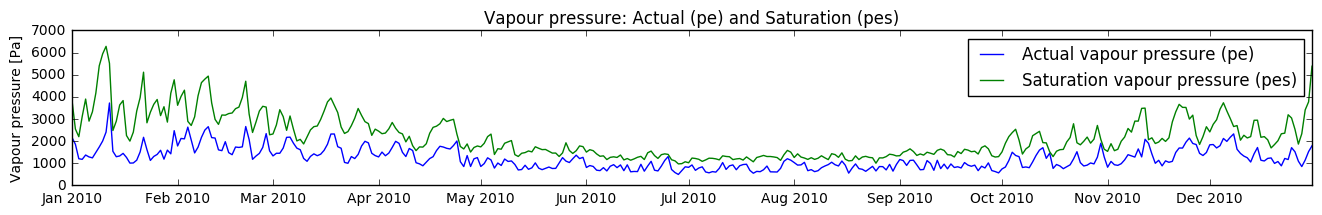

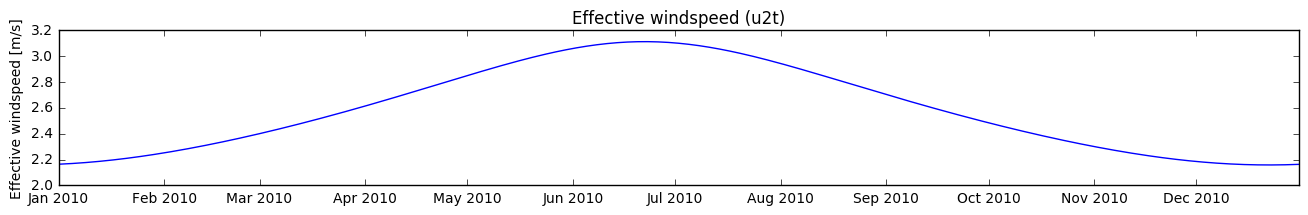

In [12]:
# Import and view calculated climate variables
# Air vapour pressure 
pair = i['pair'] #[Pa] 
# Calculate saturation vapour pressure (pes) and Actual vapour pressure (pe)
# Saturation vapour pressure [Pa] (pes) - Eqn. 35 
pes = 610.8 * np.exp(17.27 * Ta               /(237.3  + Ta              )) 

# plot it
plt.figure(figsize = (16,2))
plt.plot(pe,label='Actual vapour pressure (pe)')
plt.plot(pes,label='Saturation vapour pressure (pes)')
plt.legend()
plt.ylabel('Vapour pressure [Pa]')
plt.title('Vapour pressure: Actual (pe) and Saturation (pes)')
print('Air pressure (pair)=',pair)
# u2: Effective daily wind speed at 2m [m/s] 
# note that the wind is transformed prior according to wspeed_grid * ((1 - (1 - fday) * 0.25) / fday)
# where fday is the fraction of daylight hours
# see van Dijk (2010) Eqn [3-12] and file the below where the pretransform is undertaken
# ../../models/awrams/models/awral/transforms.py
u2 = df_clm['u2t']  
# plot wind
plt.figure(figsize = (16,2))
plt.plot(u2,label='Wind (u2t)')
plt.ylabel('Effective windspeed [m/s]')
plt.title('Effective windspeed (u2t)')

 Calculate Penman Potential evaporation (E0) [shallow/deep rooted]


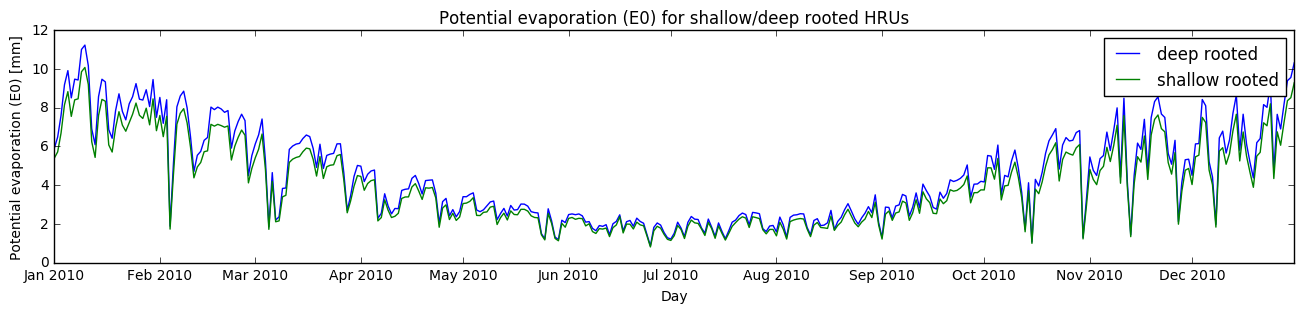

In [13]:
# c. Calculate Penman potential evaporation (E0) from a water surface according to absorbed energy

# Calculate terms required in E0 Penman (1948) E0 equation 
# Slope of the saturation vapour pressure curve (delta) - Eqn 37
delta       = 4217.457 / ((240.97 + Ta)*(240.97 + Ta)) * pes
# psychometric constant [Pa/K]
gamma       = 0.000646 * pair * (1.0 + 0.000946 * Ta)
# Latent heat of vapourisation (lambda_) [MJ kg–1]
lambda_     = 2.501 - (0.002361 * Ta)


# calculate Penman potential evaporation from a water surface according to absorbed energy
def calc_awral_E0(RSn, RLn, delta, gamma, pes, pe, u2, lambda_):
    # Inputs:
    #       RSn     : shortwave radiation net balance [MJ m–2 d–1]
    #       RLn     : longwave radiation net balance [MJ m–2 d–1]
    #       delta   : Slope of the saturation vapour pressure curve Eqn 37
    #       pes     : Saturation vapour pressure [Pa]  Eqn 35
    #       pe      : Actual vapour pressure [Pa] (pe) - Eqn 36
    #       u2      : Effective wind speed at a height of 2m [m/s]
    #       lambda_ : Latent heat of vapourisation (lambda_) [MJ kg–1]
    
    # Daily net radiation [MJ m–2 d–1]
    Rneff = RSn + RLn
    
    # Penman (1948) equation for potential evaporation (E0)  Eqn 31
    E0  = (delta * Rneff + 6.43 / 1000.0 * gamma * (pes - pe) * (1.0 + 0.536 * u2)) / (delta + gamma) / lambda_
    return E0

#  Calculate Penman potential evaporation (E0) for all timesteps over both HRUs 
# Note fveg and w0 change dynamically on a timestep basis - not constants as here
print(' Calculate Penman Potential evaporation (E0) [shallow/deep rooted]')
E0={}
for hru in [0,1]:
    E0[hru] = calc_awral_E0(RSn[hru], RLn, delta, gamma, pes, pe, u2, lambda_)

# plot it    
plt.figure(figsize = (16,3))
plt.plot(E0[0],label='deep rooted')
plt.plot(E0[1],label='shallow rooted')
plt.xlabel('Day')
plt.ylabel('Potential evaporation (E0) [mm]')
plt.title('Potential evaporation (E0) for shallow/deep rooted HRUs')
plt.legend()

### 2.3.C Calculate actual ET based on E0, water storage and vegetation state [for each HRU]

 - Calculate maximum transpiration (Etmax)
 - Calculation of Actual ET (ET FLUXES AND ROOT WATER UPTAKE)
    - Transpiration from vegetation + Landscape (Soil + Groundwater) evaporation + Interception Evaporation 

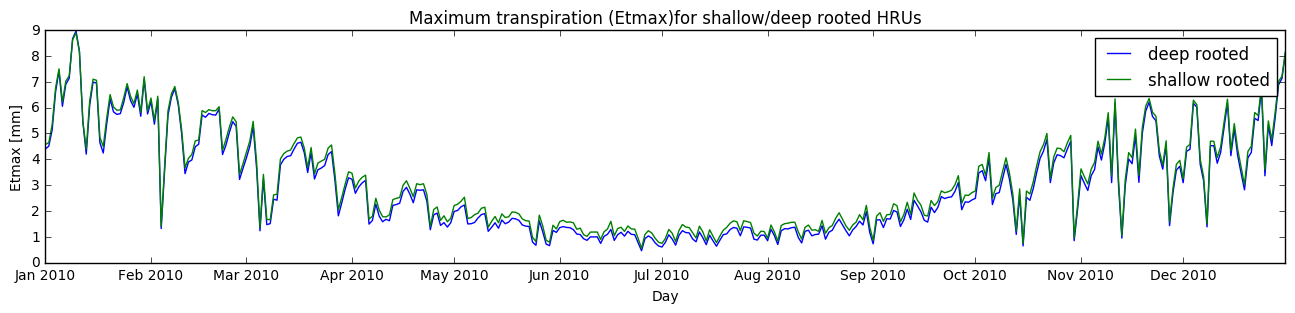

In [14]:


## Calculate maximum transpiration (Etmax), apply vegetation limitation to potential evaporation


# vegetation photosynthetic capacity index per unit canopy cover (Vc)
Vc = df_params[df_params['MemberName'].str.contains('Vc_')]['Value'].values 
cGsmax =  df_params[df_params['MemberName'].str.contains('cGsmax_')]['Value'].values
# Maximum Canopy (surface) conductance (Gsmax Eqn 57)
Gsmax       = cGsmax * Vc
# Aerodynamic conductance 
# height of the vegetation canopy [m] (hveg)
hveg = np.array([df_spgrids['hveg_dr_grid'],df_params[df_params['MemberName'].str.contains('hveg_hruSR')]['Value'].values[0]])
# Components Eqn 56
fh      = np.log(813. / hveg - 5.45)
ku2     = 0.305 / (fh * (fh + 2.3))
#ga      = ku2*u2
ga      = np.array([ku2[0]*u2,ku2[1]*u2])
# Dimensionless coefficient keps
# keps =  psychometric constant (gamma) /slope of the saturation vapour pressure curve (delta) 
# psychometric constant  = gamma       = 0.000646 * pair * (1.0 + 0.000946 * Ta)
# Slope of the saturation vapour pressure curve (delta)        = 4217.457 / ((240.97 + Ta)*(240.97 + Ta)) * pes
# see [Eqn 3-8] van Dijk (2010) for further details http://www.bom.gov.au/water/landscape/static/publications/Van_Dijk_AWRA05_TechReport3.pdf
# could have used keps=gamma/delta here
keps       = 1.4e-3 * ((Ta / 187.0) * (Ta / 187.0) + Ta / 107.0 + 1.0) * (6.36 * pair + pe) / pes

def calc_Etmax(E0, keps, fveg, Gsmax, ga):
    # Calculate Maximum transpiration
    # see section 3.3.4    
    # Inputs:
    #   E0    : Potential evaporation [mm/d]
    #   keps  : Coefficient that determines evaporation efficiency
    #   fveg  : Fractional canopy cover [-]
    #   Gsmax : Maximum Canopy (surface) conductance
    #   ga    : Aerodynamic conductance 

    # Canopy (surface) conductance 𝑔𝑠 [m/s] eqn 57
    gs          = fveg * Gsmax
    # Potential transpiration fraction (ft) Eqn 55
    ft          = 1.0 / (1.0 + (keps / (1.0 + keps)) * ga / gs)
    # Maximum transpiration
    Etmax       = ft * E0
    return Etmax

Etmax={}
for hru in [0,1]:
    Etmax[hru] = calc_Etmax(E0[hru], keps,fveg[hru], Gsmax[hru], ga[hru])

# plot it    
plt.figure(figsize = (16,3))    
plt.plot(Etmax[0],label='deep rooted')
plt.plot(Etmax[1],label='shallow rooted')
plt.xlabel('Day')
plt.ylabel('Etmax [mm]')
plt.title('Maximum transpiration (Etmax)for shallow/deep rooted HRUs')
plt.legend()


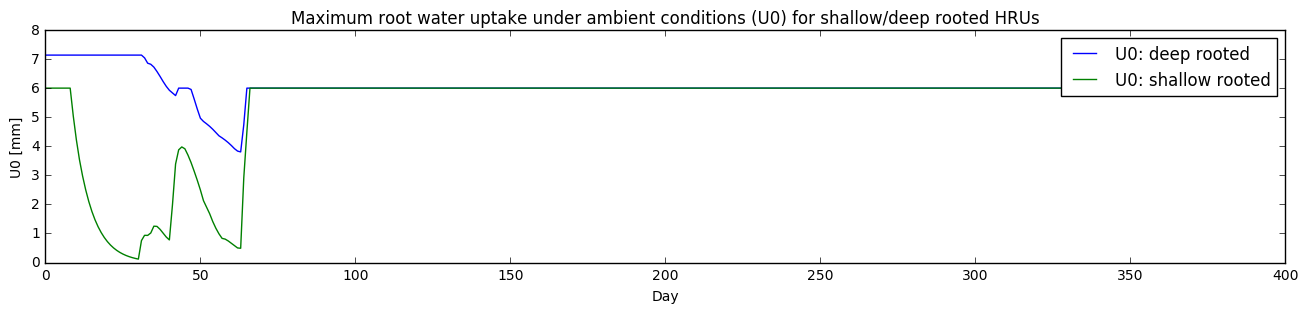

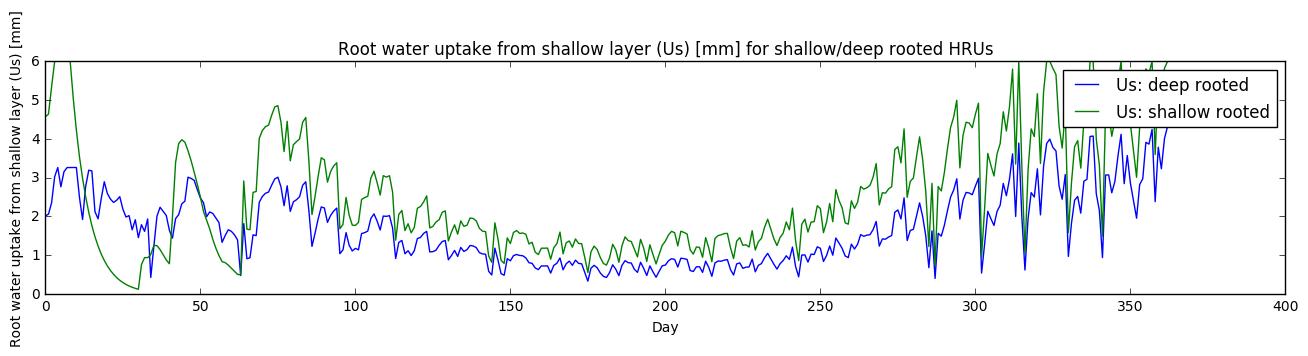

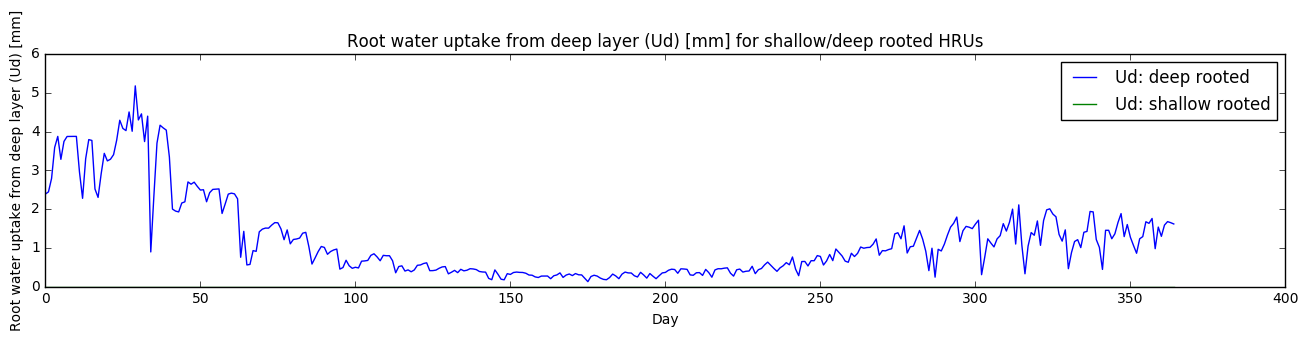

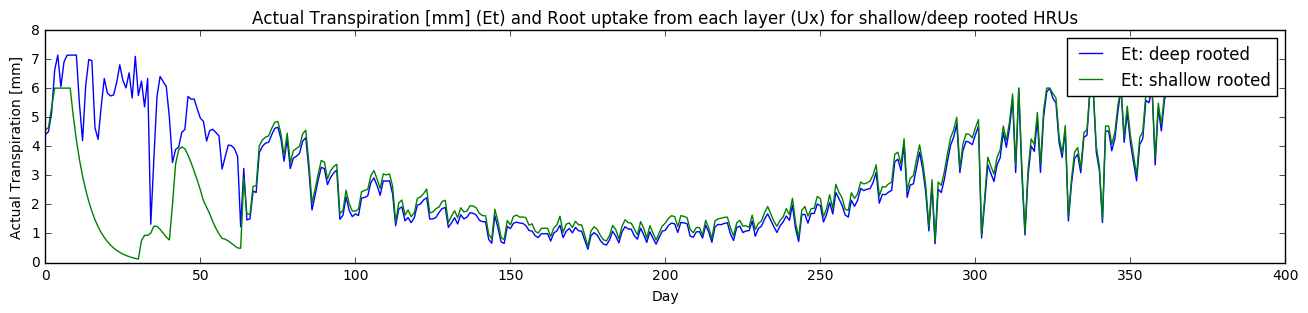

In [15]:
##  Calculation of Actual ET (ET FLUXES AND ROOT WATER UPTAKE)
##  AET= Transpiration from vegetation + Landscape (Soil + Groundwater evaporation) + Interception Evaporation  

# Calculate transpiration

# calibrated parameters 
Us0 = df_params[df_params['MemberName'].str.contains('Us0_')]['Value'].values # Maximum shallow root uptake
Ud0 = df_params[df_params['MemberName'].str.contains('Ud0_')]['Value'].values # Maximum deep root uptake
wslimU = df_params[df_params['MemberName'].str.contains('wslimU_')]['Value'].values # Water-limiting r.w.c of the shallow soil store (dimensionless)
wdlimU = df_params[df_params['MemberName'].str.contains('wdlimU_')]['Value'].values # Water-limiting r.w.c of the deep soil store (dimensionless)

# Relative soil moisture content of the shallow and deep soil layer [-] Eqn. 20 
#ws = Ss /Ssmax   # Ss=Water storage in the shallow soil layer [mm]   Ssmax=Maximum storage of the shallow soil layer (mm)
#wd = Sd /Sdmax   # Sd=Water storage in the deep soil layer [mm]   Sdmax=Maximum storage of the deep soil layer (mm)
## ATTENTION: ****************
# Use time varying soil moisture previously calculated for 
# each HRU and contained in r rather than a constant 
# value for demonstration
S0={};Ss={};Sd={};w0={};ws={};wd={}
S0[0] = r['s0_hrudr'][:,0]; w0[0]=S0[0]/S0max
S0[1] = r['s0_hrusr'][:,0]; w0[1]=S0[1]/S0max
Ss[0] = r['ss_hrudr'][:,0]; ws[0]=Ss[0]/Ssmax
Ss[1] = r['ss_hrusr'][:,0]; ws[1]=Ss[1]/Ssmax 
Sd[0] = r['sd_hrudr'][:,0]; wd[0]=Sd[0]/Sdmax  
Sd[1] = r['sd_hrusr'][:,0]; wd[1]=Sd[1]/Sdmax 


def calc_ActualTranspiration(Etmax, Us0, Ud0,wslimU, wdlimU, ws, wd, Ss,Sd ):
    # Calculation of Actual Transpiration (Et)
    # Inputs:
    #     Etmax : Potential transpiration rate [mm d–1]
    #       Us0 : Maximum possible root water uptake from the shallow soil store (mm d–1)
    #       Ud0 : Maximum possible root water uptake from the deep soil store (mm d–1)
    #    wslimU : Water-limiting relative water content of the shallow soil store(dimensionless)
    #    wdlimU : Water-limiting relative water content of the deep soil store(dimensionless)
    #        ws : Relative water content of the shallow soil store(dimensionless)
    #        wd : Relative water content of the deep soil store (dimensionless)
    #        Ss : Water content of the shallow soil store (mm)
    #        Sd : Water content of the deep soil store (mm)
    import numpy as np
    # Maximum root water uptake from shallow layer (Usmax) Eqn 51 
    Usmax =Us0*np.minimum(ws/wslimU,1.0)
    # Maximum root water uptake from deep layer  (Udmax) Eqn 52
    Udmax =Ud0*np.minimum(wd/wdlimU,1.0)
    # Maximum root water uptake under ambient conditions (U0) Eqn 50
    U0=np.maximum(Usmax, Udmax)
    
    # Actual transpiration (4.2)
    Et  = np.maximum (np.minimum (U0, np.array(Etmax)) , 0)
    Us = np.maximum(np.minimum((Usmax/(Usmax+Udmax)) * Et,Ss-0.01),0)
    Ud = np.maximum(np.minimum((Udmax/(Usmax+Udmax)) * Et,Sd-0.01),0)
    Et = Us + Ud

    return Et, Us, Ud, U0



Et={}; Us={};  Ud={};  U0 ={};
for hru in [0,1]:
    Et[hru], Us[hru], Ud[hru], U0[hru] = calc_ActualTranspiration(Etmax[hru], Us0[hru], Ud0[hru],wslimU[hru], wdlimU[hru], ws[hru], wd[hru], Ss[hru], Sd[hru] )

plt.figure(figsize = (16,3)) 
plt.plot(U0[0],label='U0: deep rooted')
plt.plot(U0[1],label='U0: shallow rooted')
plt.xlabel('Day')
plt.ylabel('U0 [mm]')
plt.title('Maximum root water uptake under ambient conditions (U0) for shallow/deep rooted HRUs')
plt.legend()      
 
plt.figure(figsize = (16,3)) 
plt.plot(Us[0],label='Us: deep rooted')
plt.plot(Us[1],label='Us: shallow rooted')
plt.xlabel('Day')
plt.ylabel('Root water uptake from shallow layer (Us) [mm]')
plt.title('Root water uptake from shallow layer (Us) [mm] for shallow/deep rooted HRUs')
plt.legend()  
plt.figure(figsize = (16,3)) 
plt.plot(Ud[0],label='Ud: deep rooted')
plt.plot(Ud[1],label='Ud: shallow rooted')
plt.xlabel('Day')
plt.ylabel('Root water uptake from deep layer (Ud) [mm]')
plt.title('Root water uptake from deep layer (Ud) [mm] for shallow/deep rooted HRUs')
plt.legend()  
plt.figure(figsize = (16,3))  
plt.plot(Et[0],label='Et: deep rooted')
plt.plot(Et[1],label='Et: shallow rooted')
plt.xlabel('Day')
plt.ylabel('Actual Transpiration [mm]')
plt.title('Actual Transpiration [mm] (Et) and Root uptake from each layer (Ux) for shallow/deep rooted HRUs')
plt.legend() 
    



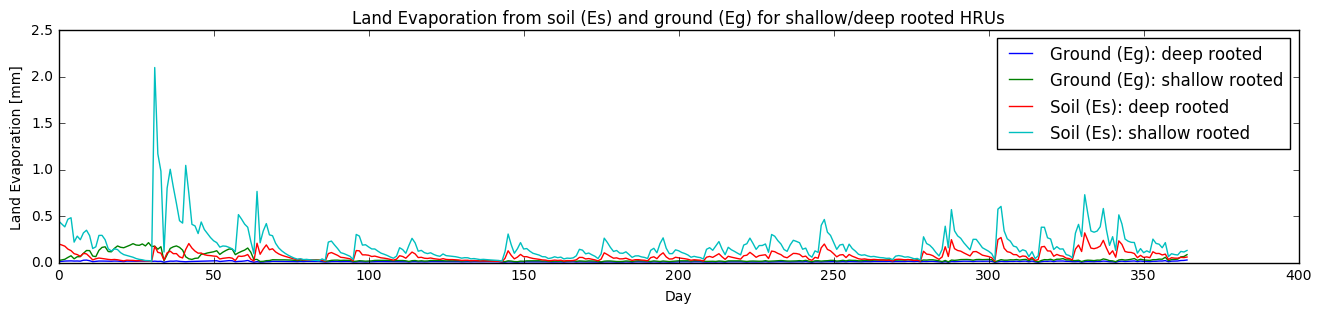

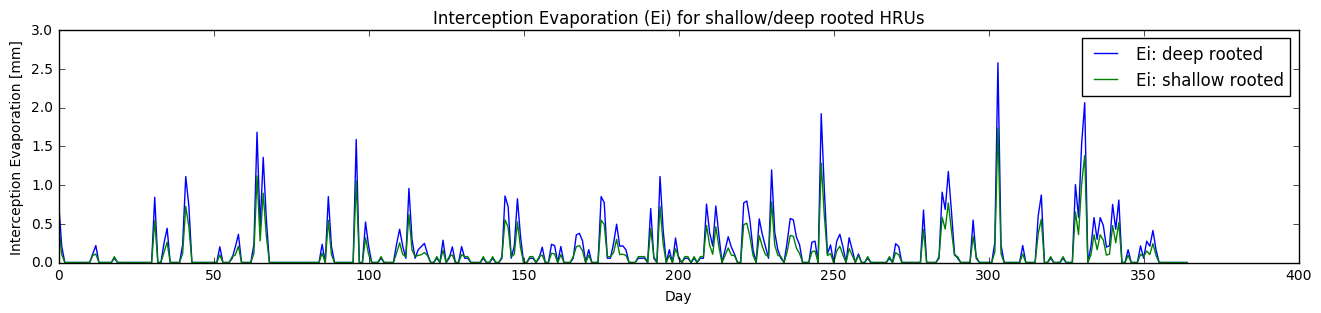

In [16]:
# Calculate land evaporation from soil (Es) and groundwater (Eg) -Section 3.3.2 and 3.3.3
# FsoilEmax: Soil evaporation scaling factor corresponding to unlimited soil water supply [-]   
FsoilEmax = df_params[df_params['MemberName'].str.contains('FsoilEmax_')]['Value'].values # 
# w0limE: E Limiting the value of w0 at which evaporation is reduced [-]
w0limE = df_params[df_params['MemberName'].str.contains('w0limE_')]['Value'].values # 
def calc_LandEvap(Et, E0, FsoilEmax, w0limE, w0, fsat):   
    # Evaporation from the land - soil and groundwater
    #  conceptualised as a fraction of the potential evaporation (E0)
    #  after transpiration (Et) has been satified.
    
    # Inputs:
    # Et: Actual total transpiration flux [mm/d]
    # E0: Potential Evaporation [mm/d]
    # FsoilEmax: Soil evaporation scaling factor corresponding to unlimited soil water supply [-]
    # w0limE: E Limiting the value of w0 at which evaporation is reduced [-]
    # fsat: Fraction of the grid cell that is saturated at the surface
    # FsoilEmax: Soil evaporation scaling factor corresponding to unlimited soil water supply [-]
    
    # Relative soil evaporation Eqn 48
    fsoilE = FsoilEmax * np.minimum(w0/w0limE,1.)
    # Soil evaporation (section 3.3.2. Eqn 47)     
    Es = (1.0 - fsat)*fsoilE* (E0  - Et)
    
    # Groundwater evaporation (section 3.3.3. Eqn 49)   
    Eg = np.maximum(0, fsat)* FsoilEmax * (E0 - Et)  # zero unless fsat >0
    return Es, Eg


Es={}; Eg={};
for hru in [0,1]:
    Es[hru], Eg[hru] = calc_LandEvap(np.array(Et[hru]), np.array(E0[hru]), FsoilEmax[hru], w0limE[hru], w0[hru], fsat) 
    
plt.figure(figsize = (16,3))    
plt.plot(Eg[0],label='Ground (Eg): deep rooted')
plt.plot(Eg[1],label='Ground (Eg): shallow rooted')
plt.plot(Es[0],label='Soil (Es): deep rooted')
plt.plot(Es[1],label='Soil (Es): shallow rooted')
plt.xlabel('Day')
plt.ylabel('Land Evaporation [mm]')
plt.title('Land Evaporation from soil (Es) and ground (Eg) for shallow/deep rooted HRUs')
plt.legend()  
    
# Calculate interception (Ei) -section 3.3.1
# Specific canopy rainfall storage per unit leaf area (S_sls)  [mm] 
S_sls = df_params[df_params['MemberName'].str.contains('S_sls_')]['Value'].values # 
# Specific ratio of the mean evaporation rate and the mean rainfall intensity during storms (ER_frac_ref) [-]
ER_frac_dr=df_params[df_params['MemberName'].str.contains('ER_frac_ref_')]['Value'].values
ER_frac_ref = [ER_frac_dr[0],ER_frac_dr[0]*.5]
               
               # 
# Gross rainfall (Pg) [mm] from input climate data
Pg = df_clm['precip_f']

def calc_InterceptionEvap(Pg, S_sls, LAI, ER_frac_ref, fveg):
    # Rainfall interception evaporation (section 3.3.1)
    
    # Inputs:
    #
    # Pg: Gross rainfall [mm] from input climate data
    # S_sls: Specific canopy rainfall storage per unit leaf area (S_sls)  [mm] 
    # LAI: Leaf Area Index [-]  (the one-sided greenleaf area per unit ground surface area)
    # ER_frac_ref: Specific ratio of the mean evaporation rate and the mean rainfall intensity during storms (ER_frac_ref) [-]
    # fveg: Fractional canopy cover [-]

    # canopy rainfall storage capacity (Sveg) [mm] Eqn 45
    Sveg = S_sls* LAI
    # ratio of average evaporation rate to average rainfall intensity (during storms) (fER) [-]
    fER = ER_frac_ref * fveg
    # reference threshold rainfall amount at which the canopy is wet [mm] Eqn 44
    Pwet = -np.log(1.0 - fER / fveg) * Sveg / fER
    # evaporation of intercepted rainfall (Ei) [mm] Eqn 43
    Ei = np.minimum(Pg, Pwet) * (fveg)    + fER*np.maximum((Pg - Pwet),0.0)
    #if(Pg < Pwet):
    #    Ei = fveg * Pg
    #else:
    #    Ei = fveg * Pwet + fER*(Pg - Pwet)
    return Ei    



# calculate interception and plot it
Ei={};
for hru in [0,1]:
    Ei[hru] = calc_InterceptionEvap(np.array(Pg), S_sls[hru], LAI[hru], ER_frac_ref[hru], fveg[hru])      
plt.figure(figsize = (16,3))    
plt.plot(Ei[0],label='Ei: deep rooted')
plt.plot(Ei[1],label='Ei: shallow rooted')
plt.xlabel('Day')
plt.ylabel('Interception Evaporation [mm]')
plt.title('Interception Evaporation (Ei) for shallow/deep rooted HRUs')
plt.legend()    

### 2.3.D. Calculate Water balance and flows [for each HRU]

  - Calculate surface flows and infiltration
  - Calculate horizontal (interflow) and vertical(drainge) fluxes at each layer
  - Update Et components (these are limited due to soil moisture availability)
  

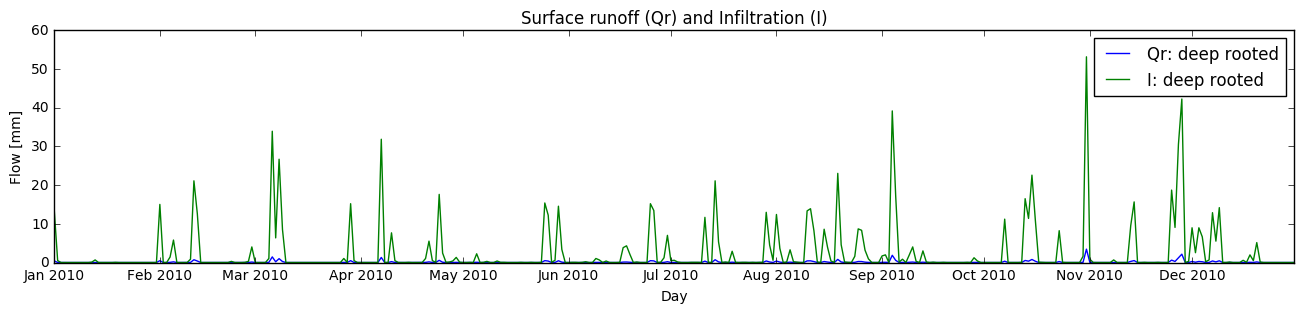

In [17]:
## Calculate surface water fluxes (Qr) and Infiltration (I) -Section 2.1.1

# Scaling factor for reference precipitation (Pref_gridscale) [-]
Pref_gridscale = df_params[df_params['MemberName'].str.contains('Pref_gridscale')]['Value'].values  # Scaling factor
# PrefR: Reference value for precipitation [mm]
PrefR = df_spgrids['pref_grid'] * Pref_gridscale # Scaled reference precipitation (Eqn 10)
    

def calc_SurFluxes(Pg, Ei, fsat, PrefR):
    # Calculate surface water fluxes (Qr) and Infiltration (I) - Section 2.1.1
    # Inputs:
    #
    # Pg: Gross rainfall [mm] from input climate data 
    # Ei: Evaporation of intercepted rainfall (Ei) [mm] Eqn 43
    # fsat: Fraction of the grid cell that is saturated at the surface [-]
    # PrefR: Reference value for precipitation [mm]
    
    # Net rainfall (Pn) [mm] Eqn 1
    Pn = np.maximum(0.0,Pg-Ei);
    # Infiltration-excess runoff component (rhof=Qh) Eqn 9
    rhof = (1.0 - fsat)*(Pn - (PrefR*np.tanh(Pn/PrefR))); # hortonian flow where infiltration cannot cope with inundation
    # Saturation-excess runoff component (rsof=Qs)  Eqn 8  
    rsof = fsat * Pn; # where the catchment is saturated
    # Surface runoff (Qr) - Infiltration excess + saturation excess 
    Qr = rhof + rsof;
    # Infiltration (I) Eqn 2.
    I = Pn - Qr;
    return Qr, I

# Calculate it for each HRU and plot it
Qr={};I={};
for hru in [0,1]:
    Qr[hru], I[hru] = calc_SurFluxes(Pg, Ei[hru], fsat, PrefR)
plt.figure(figsize = (16,3))    
plt.plot(Qr[0],label='Qr: deep rooted')
#plt.plot(Qr[1],label='Qr" shallow rooted')
plt.plot(I[0],label='I: deep rooted')

plt.xlabel('Day')
plt.ylabel('Flow [mm]')
plt.title('Surface runoff (Qr) and Infiltration (I)')
plt.legend()    

K0sat=[ 2617.01963522]
Kssat=[ 0.8579423]
Kdsat=[ 0.20233079]


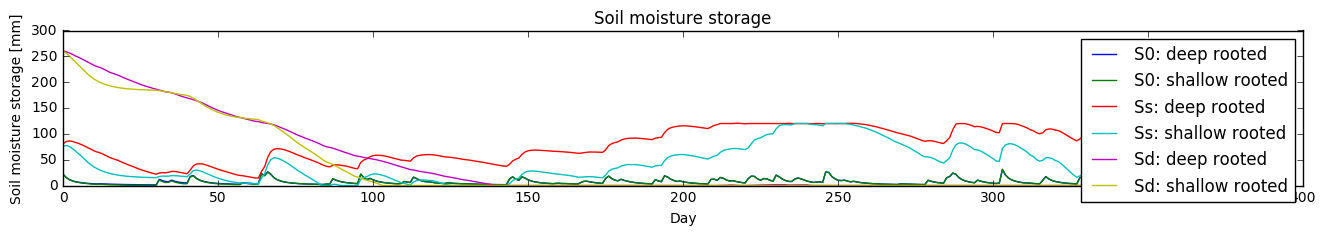

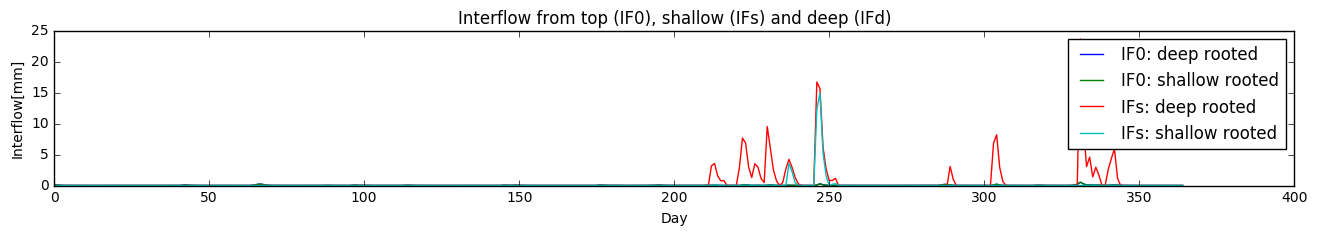

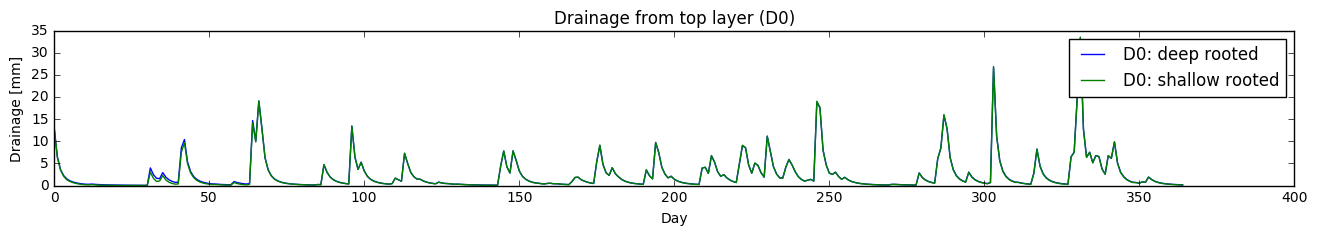

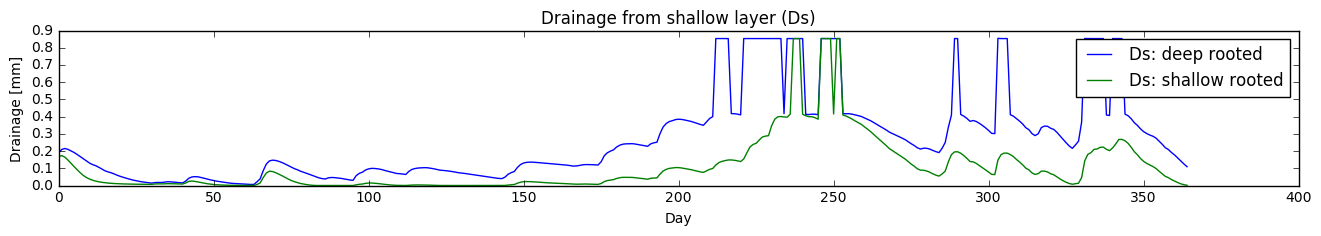

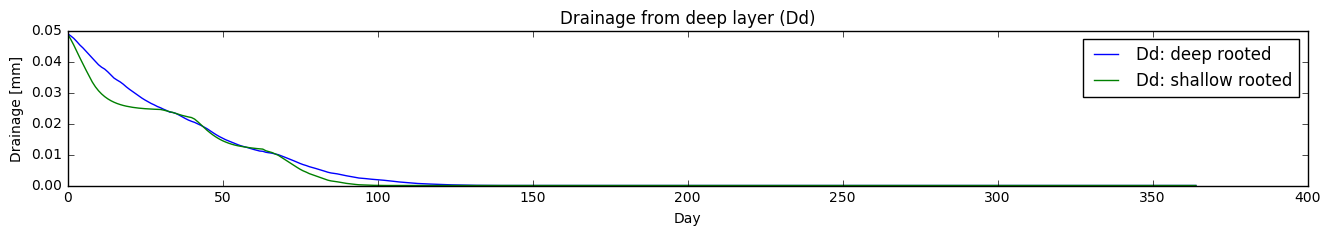

In [18]:
## Calculate horizontal (interflow) and vertical(drainage) fluxes at each layer - Section 2.1.2
#  
# Parameters:
# read in Scaling factor for slope [-]
slope_coeff = df_params[df_params['MemberName'].str.contains('slope_coeff')]['Value'].values
# slope [percent] = gridded slope * slope scaling coefficient
slope_eff = df_spgrids['slope_grid'] * slope_coeff
# Scaling factor for ratio of saturated hydraulic conductivity [Kr_coeff]
Kr_coeff =  df_params[df_params['MemberName'].str.contains('Kr_coeff')]['Value'].values # Scaling factor for upper: lower layer ratio of 
# Scaling factors for hydraulic conductivity of soil layers                                                                                      # saturated hydraulic conductivity (dimensionless)
K0sat_scale = df_params[df_params['MemberName'].str.contains('K0sat_scale')]['Value'].values
Kssat_scale = df_params[df_params['MemberName'].str.contains('Kssat_scale')]['Value'].values
Kdsat_scale = df_params[df_params['MemberName'].str.contains('Kdsat_scale')]['Value'].values
# Grids for hydraulic conductivity of soil layers    
K0sat = df_spgrids['k0sat_v5_grid'] * K0sat_scale
Kssat = df_spgrids['kssat_v5_grid'] * Kssat_scale
Kdsat = df_spgrids['kdsat_v5_grid'] * Kdsat_scale
# Pre-calculated relative hydraulic conductivities (kr)
Kr_0s = K0sat / Kssat; adj_Kr0s = (Kr_0s-1)*Kr_coeff
Kr_sd = Kssat / Kdsat; adj_Krsd = (Kr_sd-1)*Kr_coeff
# Pre-calculated geometric mean of conductivities (km)
Km_s0 = pow((K0sat * Kssat),0.5)
Km_ss = pow((Kssat * Kdsat),0.5)
Km_sd = Kdsat

def calc_soil_flows(I, slope_eff, e, s, smax, w,  ksat, kr, km, horizflow = True ):
    ## Calculate horizontal (interflow) and vertical(drainage) fluxes at each layer - Section 2.1.2
    # 
    # Inputs
    #
    # I: Infiltration or drainage from soil layer above (mm)
    # slope_eff: slope [percent]
    # e: Root water uptake =transpiration
    # s: storage of soil layer [mm]
    # smax: maximum water storage of soil layer [mm] 
    # w: relative soil moisture content of layer [-]
    # ksat: hydraulic conductivity of soil layers
    # kr: relative hydraulic conductivities
    # km: geometric mean of conductivities
    # horitontal: Lateral interflow only occurs for top and shallow layers (=True), swtchoff for deep
    #
    # Outputs:
    # drain= vertical drainage
    # iflow=lateral drainage
    
    drain = np.zeros(2); iflow = np.zeros(2)
    rh = np.zeros(2) # relative horizontal conductivity
    if horizflow:
        # Partitioning factor for vertical and lateral drainage from the soil layer (rh) -Eqn 21 and 22
        # rh = proportion overall drainage from layer lateral/interflow
        rh = np.tanh(slope_eff*w)*np.tanh(kr*w)
    for  hru, infil in enumerate(I):
        if (s[hru]+I[hru]) <= e[hru]: 
        # If (root water uptake demand) > (storage and inflow from above) then lose all water to transpiration
            e[hru] = s[hru] + I[hru]  # limit transpiration to storage + inflow
            s[hru] = 0.0;     # no remaining storage
            drain[hru] = 0.0; # no vertical drainage
            iflow[hru] = 0.0; # no interflow
        elif (smax-s[hru]+ksat) <= (I[hru]-e[hru]):
        # If s[hru] greater than maximum capacity smax even after draining at maximum 
        # drainage rate (Ksat), also taking away lost transpiraiton e[hru] and adding I[hru]
        # ie. rearranging the following where t1 and t2 are timesteps
        # s[hru]_t2=s[hru]_t1 + I[hru] -e[hru]- ksat  
        #          >smax              
            drain[hru] = (1 - rh[hru]) * ksat;
            iflow[hru] = (rh[hru] * ksat) + (s[hru] - smax - ksat + I[hru] - e[hru]);
            s[hru] = smax;
        else:
        # If neither above maximum storage or going to run out of water
        # drain according to the defined drainage equations Equations 11-13
        # Timestep equation solved quadratically according to Viney et al (2015)
        # http://www.bom.gov.au/water/landscape/static/publications/Viney_et_al_2015_AWRA_L_5.0_model_description.pdf
        # 3.2.2.3 Updating equations for water balance of each soil layer Eqn 22-24
            a = km / (smax*smax);
            b = 1.0;
            c = -(s[hru] + I[hru] - e[hru]);
            s[hru] = (-b + (pow(b * b - 4. * a * c, 0.5))) / (2. * a);

            pfull = (s[hru]/smax);
            drain[hru] = (1 - rh[hru]) * km * pfull * pfull
            iflow[hru] = rh[hru] * km * pfull * pfull   
    
    return(drain, iflow, e, s)



# Required to loop over timesteps here for demonstration as function uses an if loop so cannot pass timeseries array
# Note this loop does not have vegetation or energy balance feedbacks - demonstration only.
# store outputs in these dictionaries for plotting
D0dict={};S0dict={};IF0dict={};Dsdict={};Ssdict={};IFsdict={};Dddict={};Sddict={};IFddict={};Esdict={};Usdict={};Uddict={};
for hru in [0,1]:     
    D0dict[hru]=[];S0dict[hru]=[];IF0dict[hru]=[];Dsdict[hru]=[];Ssdict[hru]=[];IFsdict[hru]=[]
    Dddict[hru]=[];Sddict[hru]=[];IFddict[hru]=[];Esdict[hru]=[];Usdict[hru]=[];Uddict[hru]=[];
# initialise soil stores
cnt=0
S0val=np.array([S0[0][cnt],S0[1][0]])
Ssval=np.array([Ss[0][cnt],Ss[1][0]])
Sdval=np.array([Sd[0][cnt],Sd[1][0]])    
### Start period loop
for cnt, day in enumerate(df_clm.index):
    
    # pass in input values for drainage calculations - from previous calculations
    Ival=np.array([I[0][cnt],I[1][cnt]])
    Esval=np.array([Es[0][cnt],Es[1][cnt]])
    Usval=np.array([Us[0][cnt],Us[1][cnt]])       
    Udval=np.array([Us[0][cnt],Us[1][cnt]])  

    # these variables are altered at each timestep
    w0val=S0val/S0max
    wsval=Ssval/Ssmax
    wdval=Sdval/Ssmax   

    # Drainage calculations for each layer
    D0, IF0, Escal, S0val = calc_soil_flows(Ival, slope_eff, e = Esval,  s = S0val, smax = S0max, w=w0val, ksat = K0sat, kr = adj_Kr0s, km = Km_s0, horizflow = True) 
    Ds, IFs, Uscal, Ssval = calc_soil_flows(D0,   slope_eff, e = Usval,  s = Ssval, smax = Ssmax, w=wsval, ksat = Kssat, kr = adj_Krsd, km = Km_ss, horizflow = True)
    Dd, IFd, Udcal, Sdval = calc_soil_flows(Ds,   slope_eff, e = Udval,  s = Sdval, smax = Sdmax, w=wdval, ksat = Kdsat, kr = 0       , km = Km_sd, horizflow = False)    
    
    for hru in [0,1]:
        D0dict[hru].append(D0[hru]);   S0dict[hru].append(S0val[hru]);IF0dict[hru].append(IF0[hru])
        Dsdict[hru].append(Ds[hru]);   Ssdict[hru].append(Ssval[hru]);IFsdict[hru].append(IFs[hru])
        Dddict[hru].append(Dd[hru]);   Sddict[hru].append(Sdval[hru]);IFddict[hru].append(IFd[hru])
        Esdict[hru].append(Escal[hru]);Usdict[hru].append(Uscal[hru]);Uddict[hru].append(Udval[hru])
    
plt.figure(figsize = (16,2))    
plt.plot(S0dict[0],label='S0: deep rooted')
plt.plot(S0dict[1],label='S0: shallow rooted')
plt.plot(Ssdict[0],label='Ss: deep rooted')
plt.plot(Ssdict[1],label='Ss: shallow rooted')
plt.plot(Sddict[0],label='Sd: deep rooted')
plt.plot(Sddict[1],label='Sd: shallow rooted')
#plt.plot(Qr[1],label='Qr" shallow rooted')
plt.xlabel('Day')
plt.ylabel('Soil moisture storage [mm]')
plt.title('Soil moisture storage')
plt.legend()    

plt.figure(figsize = (16,2))    
plt.plot(IF0dict[0],label='IF0: deep rooted')
plt.plot(IF0dict[1],label='IF0: shallow rooted')
plt.plot(IFsdict[0],label='IFs: deep rooted')
plt.plot(IFsdict[1],label='IFs: shallow rooted')
#plt.plot(Qr[1],label='Qr" shallow rooted')
plt.xlabel('Day')
plt.ylabel('Interflow[mm]')
plt.title('Interflow from top (IF0), shallow (IFs) and deep (IFd)')
plt.legend()  

plt.figure(figsize = (16,2))   
plt.plot(D0dict[0],label='D0: deep rooted')
plt.plot(D0dict[1],label='D0: shallow rooted')
plt.xlabel('Day')
plt.title('Drainage from top layer (D0)')
plt.ylabel('Drainage [mm]')
plt.legend()     
plt.figure(figsize = (16,2))
plt.plot(Dsdict[0],label='Ds: deep rooted')
plt.plot(Dsdict[1],label='Ds: shallow rooted')
plt.xlabel('Day')
plt.title('Drainage from shallow layer (Ds)')
plt.ylabel('Drainage [mm]')
plt.legend() 
plt.figure(figsize = (16,2))   
plt.plot(Dddict[0],label='Dd: deep rooted')
plt.plot(Dddict[1],label='Dd: shallow rooted')
plt.xlabel('Day')
plt.title('Drainage from deep layer (Dd)')
plt.ylabel('Drainage [mm]')
plt.legend() 
#plt.plot(Eslist,label='Es: deep rooted')
#plt.plot(Qr[1],label='Qr" shallow rooted')
   
print('K0sat='+ str(K0sat))
print('Kssat='+ str(Kssat))
print('Kdsat='+ str(Kdsat))

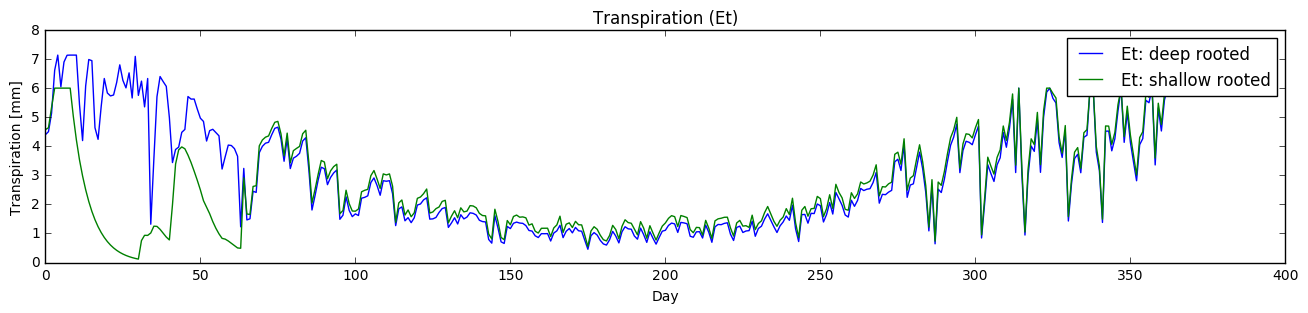

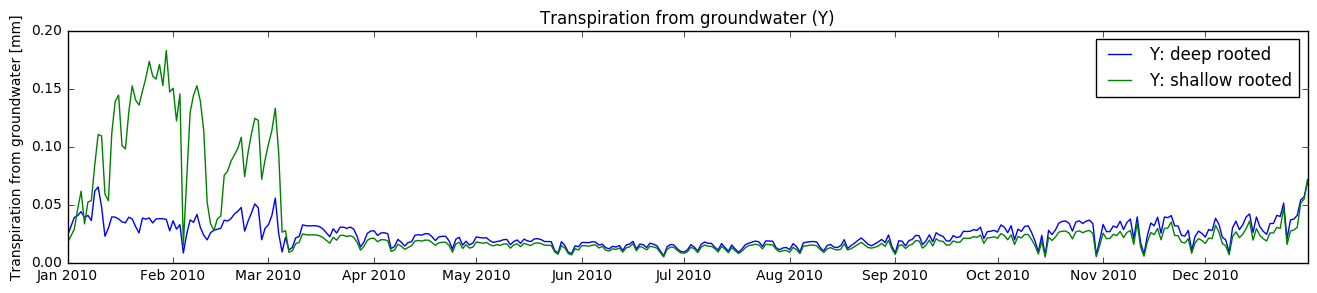

In [19]:
## Update Et components (these are limited due to soil moisture availability)
def update_Et(Us, Ud):
    return Us + Ud
## Transpiration from groundwater (Y)
def calc_Y(fEgt, fsat, E0, Et, FsoilEmax):
    Y=( np.maximum(0, (fEgt - fsat)*FsoilEmax*(E0-Et)))
    return Y

Y={};Et={}
for hru in [0,1]:
    Et[hru]  = update_Et(Us[hru], Ud[hru])
    Y[hru]= calc_Y(fEgt[hru], fsat, E0[hru], Et[hru], FsoilEmax[hru])
    
plt.figure(figsize = (16,3))    
plt.plot(Et[0],label='Et: deep rooted')
plt.plot(Et[1],label='Et: shallow rooted')
plt.xlabel('Day')
plt.ylabel('Transpiration [mm]')
plt.title('Transpiration (Et)')
plt.legend()   
plt.figure(figsize = (16,3))
plt.plot(Y[0],label='Y: deep rooted')
plt.plot(Y[1],label='Y: shallow rooted')
plt.ylabel('Transpiration from groundwater [mm]')
plt.title('Transpiration from groundwater (Y)')
plt.legend()    

### 2.3.E Calculate Vegetation growth and senescence [for each HRU]

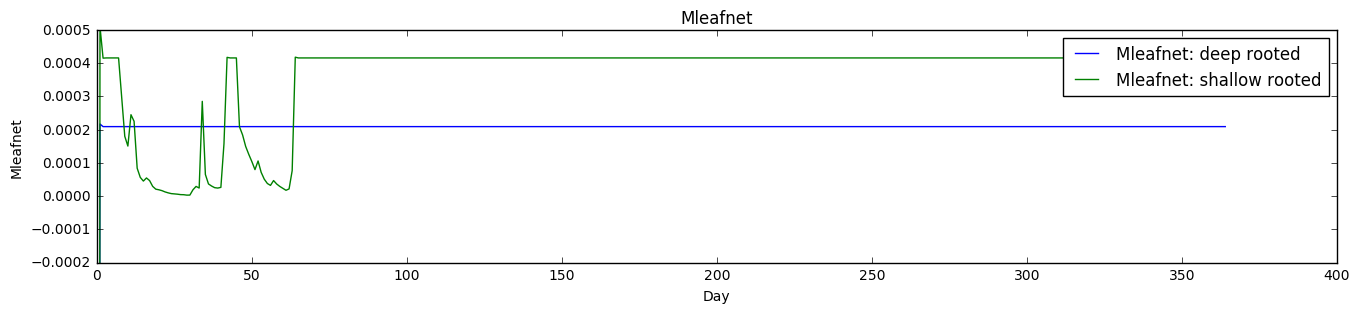

In [20]:
## Vegetation balance - Section 4

#    LAIref=reference leaf are index [-] corresponding to 𝑓𝑣 = 0.63.
LAIref = df_params[df_params['MemberName'].str.contains('LAIref_')]['Value'].values 
# fvmax= Maximum achievable canopy cover Eqn 65
fvmax = 1. - np.exp(-max(LAImax,0.0027777778450399637)/LAIref)
# Tgrow=characteristic time scale for vegetation growth towards equilibrium
Tgrow = df_params[df_params['MemberName'].str.contains('Tgrow_')]['Value'].values 
# Tsenc=characteristic time scale for vegetation senescencetowards equilibrium
Tsenc = df_params[df_params['MemberName'].str.contains('Tsenc_')]['Value'].values 

def calc_Mleaf(fvmax, E0, U0, keps, ga, Gsmax, Mleaf, SLA, Tgrow, Tsenc,LAIref):
    # Calculate vegetation mass Mleaf - Section 4 - according to equilibrium model
    #
    # Inputs:
    #    fvmax  = Maximum achievable canopy cover
    #    E0     = Potential evaporation [mm/day]
    #    U0     = maximum root water uptake under ambient conditions[mm/day]
    #    keps   = coefficient that determines evaporation efficiency
    #    ga     = Aerodynamic conductance
    #    Gsmax  = Maximum Canopy (surface) conductance
    #    Mleaf  = vegetation mass
    #    SLA    = Specific leaf area
    #    Tgrow  = characteristic time scale for vegetation growth towards equilibrium
    #    Tsenc  = characteristic time scale for vegetation senescencetowards equilibrium
    #    LAIref = reference leaf are index [-] corresponding to 𝑓𝑣 = 0.63.
    
    
    # Equilibrium canopy cover (fveq) [-] Eqn 54
    fveq =   np.array(1. / np.maximum((E0 / U0) - 1., 1e-3)) * (keps / (1. + keps)) * (ga /                                                                                      
                                                                                       Gsmax)
    fveq =   np.minimum(fveq, fvmax)
    
    # Equilibrium leaf mass Eqn 55
    #  dMleaf=equilibrium leaf mass   - current leaf mass Mleaf
    dMleaf      =   -np.log(1. - fveq) * LAIref / SLA - Mleaf
    
    # Mass balance and equation for veg to move towards equilibrium mass Eqn 61 and 62
    Mleafnet = np.maximum(dMleaf/Tgrow,0.0) + np.minimum(dMleaf/Tsenc, 0.0)

    return Mleafnet

### Start period loop
# Required to loop over timesteps here for demonstration as function uses an if loop so cannot pass timeseries array
# Note this loop does not have any vegetation or energy balance feedbacks - demonstration only.
Mleafnet={};
for hru in [0,1]:     
    Mleafnet[hru]=[]
for cnt, day in enumerate(df_clm.index):
    for hru in [0,1]:        
        Mleaf[hru]=calc_Mleaf(fvmax[hru], E0[hru][cnt], U0[hru][cnt], np.array(keps[hru]), ga[hru][cnt], Gsmax[hru], Mleaf[hru]
                                     , SLA[hru], Tgrow[hru], Tsenc[hru],LAIref[hru])
        Mleafnet[hru].append(Mleaf[hru])

plt.figure(figsize = (16,3))    
plt.plot(Mleafnet[0],label='Mleafnet: deep rooted')
plt.plot(Mleafnet[1],label='Mleafnet: shallow rooted')

plt.xlabel('Day')
plt.ylabel('Mleafnet')
plt.title('Mleafnet')
plt.ylim([-0.0002,0.0005])
plt.legend()        
            


# 2.3.F. Get cell values of variables weighting shallow and deep rooted components depending on fraction of each

In [21]:
## 13. Catchment/cell water balance  
# Get cell values of variables weighting shallow and deep rooted components depending on fraction of each
#  - undertake mass balance on each store component 
#  - weight each HRU water balance according to fraction Fhru
import math
frac_dr = df_spgrids['f_tree_grid']
# fraction deep and shallow rooted Fhru
Fhru = np.array([frac_dr, 1-frac_dr])
# Groundwater drainage coefficient (K_gw) [d-1]
K_gw = df_params[df_params['MemberName'].str.contains('K_gw_scale')]['Value'].values * df_spgrids['k_gw_grid']

def calc_GWStore(Sg, Dd, Y, Eg, Fhru ,K_gw):
    import numpy as np
    # Groundwater store water balance (Sg) (Section 2.1.3)
    # Mass balance St2=St1+drainage-baseflow-evaporation
    # start first only adding drainage
    Sg        =   Sg + np.dot(Fhru,Dd)
    # Groundwater discharge to stream / Baseflow (Eqn 24)
    Qg        =   (1. - np.exp(-K_gw)) * np.maximum(0.0, Sg)
    # adding/subtract remaining terms
    Sg        =   Sg - Qg - np.dot(Fhru,Eg) - np.dot(Fhru,Y)
    return Sg, Qg

def calc_Runoff(IF0, IFs, Qr, Fhru):
    # Total interflow (Qif) Eqn 23
    Qif = np.dot(Fhru, IFs+IF0)
    # Total surface runoff
    Qrx = np.dot(Fhru, Qr)
    return Qrx, Qif


# Rate coefficient controlling discharge to stream Eqn 30
K_rout = df_params[df_params['MemberName'].str.contains('K_rout_scale')]['Value'].values *  df_spgrids['meanpet_grid'] + \
         df_params[df_params['MemberName'].str.contains('K_rout_int')]['Value'].values   
# Linear routing delay factor Eqn 29
Kd = (1. - math.exp(-K_rout))

def calc_RiverStore(Sr,QRx, Qif, Qg, Kd):
    Sz = max(0.0,(Sr + QRx + Qg + Qif))
    Qtot = min(Sz,(Kd * Sz))
    Sr = Sz - Qtot
    return (Qtot,Sr)

for cnt, day in enumerate(df_clm.index):
    
    # use previously calculated inputs...
    Ytemp=[Y[0][cnt],Y[1][cnt]]
    Egtemp=[Eg[0][cnt],Eg[1][cnt]]
    Qrtemp=[Qr[0][cnt],Qr[1][cnt]]
    
    Sg, Qg = calc_GWStore(Sg, Dd, Ytemp, Egtemp, Fhru ,K_gw)
    QRx, Qif= calc_Runoff(IF0, IFs, Qrtemp, Fhru)
    Qtot,  Sr = calc_RiverStore(Sr,  QRx, Qif, Qg, Kd)

# 3. Run AWRA-L Python code together incorporating time loop (and dynamic feedbacks)


 1. Pre-calculate and convert constants for use in the model
 2. Initialise models states
 3. Loop over Timesteps [**ATTENTION**: Daily looping IS  undertaken here]
 
    - A. Calculate saturated fraction of cell/catchment for a given groundwater storage (Sg) [a single store - no HRUs]
    - B. Calculate potential evaporation (E0) according to Energy balance [for each HRU]
    - C. Calculate actual ET based on E0, water storage and vegatation state [for each HRU]
    - D. Calculate Water balance and flows [for each HRU]
    - E. Calculate Vegetation growth and senescence [for each HRU]
    - F. Get cell values of variables weighting shallow and deep rooted components depending on fraction of each
    
   End loop

In [22]:
import copy

In [23]:
## Running the model over my_extent and my_period 
#    - Pre-calculate and convert constants for use in the model
#    - Initialise models states

## Calculate clear sky radiation RadClearSky over the time period = calc_clrskyrad(g0_frac, latitude, period)
RadClearSky = pd.Series(calc_clrskyrad(g0_frac = 0.8, latitude = my_extent.latitudes.to_degrees() , period = my_period), index = df_clm.index)
pe = 610.8 * np.exp(17.27 * df_clm['tmin_f'] / (237.3 + df_clm['tmin_f']))  # Actual vapour pressure [Pa] (pe) - Eqn 36
pes= 610.8 * np.exp(17.27 * Ta /(237.3 + Ta))                               # Saturation vapour pressure [Pa] (pes) - Eqn. 35 
### Incoming shortwave radiation
Rgeff       = df_clm['solar_f']  #Wm-2
StefBolz  = 5.67e-8 # Black-body irradiance
### Penman potential evaporation (E0) terms
delta       = 4217.457 / ((240.97 + Ta)*(240.97 + Ta)) * pes # Slope of the saturation vapour pressure curve (delta) - Eqn 37
gamma       = 0.000646 * pair * (1.0 + 0.000946 * Ta) # psychometric constant [Pa/K]
lambda_     = 2.501 - (0.002361 * Ta) # Latent heat of vapourisation (lambda_) [MJ kg–1]
## Add these inputs to a dataframe
df_PET = pd.concat([Ta,pe, pes, RadClearSky, Rgeff, delta, gamma, lambda_], axis = 1, ignore_index=False)
df_PET.columns = ['Ta','pe', 'pes', 'RadClearSky', 'Rgeff','delta', 'gamma', '_lambda_']
# Hypsometric curve related properties
height = df_hypso['Value']; # height: set of Hysometric curve heights  - see section 2.1.3
Hypsfsat = df_hypso['Percent_saturated'] # Hypsfsat: set of Hysometric curve fsat values for each height value
npctiles = 20 # number of percentiles = len(Hypsfsat)
ne_scale=df_params[df_params['MemberName']=='ne_scale']['Value'].values # ne_scale: optimised parameter used to scale gridded ne value
ne = df_spgrids['ne_grid']*ne_scale # ne: Effective porosity - required to translate hypsometric curve values to equivalent Sg values
RD = df_params[df_params['MemberName'].str.contains('RD_')]['Value'].values # RD: Root Depth for shallow and deep rooted vegetation (currently set to 1m, 6m respectively)
EffRD=RD*1000*ne # effective root depth

# Albedo properties
w0ref_alb  = df_params[df_params['MemberName'].str.contains('w0ref_alb_')]['Value'].values #Reference value of w0 that determines the rate of albedo decrease with wetness
alb_dry = df_params[df_params['MemberName'].str.contains('alb_dry')]['Value'].values # Dry soil albedo [-]
alb_wet = df_params[df_params['MemberName'].str.contains('alb_wet')]['Value'].values # Wet soil albedo [-]
alb_veg   = 0.452 * Vc # Vegetation albedo (alb_veg) - Eqn. 41
# Vegetation properties
Vc = df_params[df_params['MemberName'].str.contains('Vc_')]['Value'].values # Vegetation photosynthetic capacity index per unit canopy cover (Vc)
SLA = df_params[df_params['MemberName'].str.contains('SLA_')]['Value'].values # Specific leaf area
cGsmax =  df_params[df_params['MemberName'].str.contains('cGsmax_')]['Value'].values
Gsmax       = cGsmax * Vc # Maximum Canopy (surface) conductance (Gsmax Eqn 57)
# Aerodynamic conductance - Components Eqn 56
hveg = np.array([df_spgrids['hveg_dr_grid'],df_params[df_params['MemberName'].str.contains('hveg_hruSR')]['Value'].values[0]])
fh      = np.log(813. / hveg - 5.45)
ku2     = 0.305 / (fh * (fh + 2.3))
ga_dr      = ku2[0]*df_clm['u2t'];ga_sr = ku2[1]*df_clm['u2t'];
keps    = 1.4e-3 * ((Ta / 187.0) * (Ta / 187.0) + Ta / 107.0 + 1.0) * (6.36 * pair + pe) / pes #kep=gamma/delta=psychometric constant (gamma) /slope of the saturation vapour pressure curve (delta) 

### Vegetation moisture uptake properties
Us0 = df_params[df_params['MemberName'].str.contains('Us0_')]['Value'].values # Us0: Maximum shallow root uptake
Ud0 = df_params[df_params['MemberName'].str.contains('Ud0_')]['Value'].values # Ud0: Maximum deep root uptake
wslimU = df_params[df_params['MemberName'].str.contains('wslimU_')]['Value'].values # wslimU: Water-limiting r.w.c of the shallow soil store (dimensionless)
wdlimU = df_params[df_params['MemberName'].str.contains('wdlimU_')]['Value'].values # wdlimU: Water-limiting r.w.c of the deep soil store (dimensionless)
FsoilEmax = df_params[df_params['MemberName'].str.contains('FsoilEmax_')]['Value'].values # FsoilEmax: Soil evaporation scaling factor corresponding to unlimited soil water supply [-]
w0limE = df_params[df_params['MemberName'].str.contains('w0limE_')]['Value'].values # w0limE: Limiting the value of w0 at which evaporation is reduced [-]
S_sls = df_params[df_params['MemberName'].str.contains('S_sls_')]['Value'].values # S_sls: Specific canopy rainfall storage per unit leaf area [mm]  
ER_frac_dr=df_params[df_params['MemberName'].str.contains('ER_frac_ref_')]['Value'].values # ER_frac_dr: Deep rooted vegetation: Specific ratio of the mean evaporation rate and the mean rainfall intensity during storms 
ER_frac_ref = [ER_frac_dr[0],ER_frac_dr[0]*.5] # ER_frac_ref: Specific ratio of the mean evaporation rate and the mean rainfall intensity during storms [deep rooted, shallow rooted=half deep rooted]
### Vegetation growth
LAIref = df_params[df_params['MemberName'].str.contains('LAIref_')]['Value'].values #    LAIref: reference leaf are index [-] corresponding to 𝑓𝑣 = 0.63.
fvmax = 1. - np.exp(-max(LAImax,0.0027777778450399637)/LAIref) # fvmax: Maximum achievable canopy cover Eqn 65
Tgrow = df_params[df_params['MemberName'].str.contains('Tgrow_')]['Value'].values # Tgrow: characteristic time scale for vegetation growth towards equilibrium
Tsenc = df_params[df_params['MemberName'].str.contains('Tsenc_')]['Value'].values # Tsenc: characteristic time scale for vegetation senescencetowards equilibrium 

# Capacity of soil stores and drainage properties
s0max_scale = df_params[df_params['MemberName'].str.contains('S0max_scale')]['Value'].values # s0max_scale: Scaling parameter for maximum storage of the surface (0-10cm) soil layer [-]
ssmax_scale = df_params[df_params['MemberName'].str.contains('Ssmax_scale')]['Value'].values # ssmax_scale: Scaling parameter for maximum storage of the shallow (10-100cm) soil layer [-] : Eqn 15
sdmax_scale = df_params[df_params['MemberName'].str.contains('Sdmax_scale')]['Value'].values # sdmax_scale: Scaling parameter for maximum storage of the deep (100-600cm) soil layer [-] : Eqn 16
S0max = 100*df_spgrids['s0fracawc_grid']*s0max_scale # S0max: maximum storage of the surface (0-10cm) soil layer [mm] : Eqn 14
Ssmax = 900*df_spgrids['ssfracawc_grid']*ssmax_scale # Ssmax: maximum storage of the shallow (10-100cm) soil layer [mm] : Eqn 15
Sdmax = 5000/900*Ssmax*sdmax_scale # Sdmax: maximum storage of the deep (100-600cm) soil layer [mm] : Eqn 16
# Soil properties for runoff, drainage
Pref_gridscale = df_params[df_params['MemberName'].str.contains('Pref_gridscale')]['Value'].values  # Pref_gridscale: Scaling factor for reference precipitation (Pref_gridscale) [-]
PrefR = df_spgrids['pref_grid'] * Pref_gridscale # PrefR: Reference value for precipitation [mm]
slope_coeff = df_params[df_params['MemberName'].str.contains('slope_coeff')]['Value'].values # slope_coeff: Scaling factor for slope [-]
slope_eff = df_spgrids['slope_grid'] * slope_coeff # slope_eff: effective slope [percent] = gridded slope * slope scaling coefficient
Kr_coeff  =  df_params[df_params['MemberName'].str.contains('Kr_coeff')]['Value'].values    # Kr_coeff: Scaling factor for ratio of saturated hydraulic conductivity 
# Scaling factors for hydraulic conductivity of soil layers
K0sat_scale = df_params[df_params['MemberName'].str.contains('K0sat_scale')]['Value'].values
Kssat_scale = df_params[df_params['MemberName'].str.contains('Kssat_scale')]['Value'].values
Kdsat_scale = df_params[df_params['MemberName'].str.contains('Kdsat_scale')]['Value'].values
# ksat: hydraulic conductivity of soil layers 
K0sat = df_spgrids['k0sat_v5_grid'] * K0sat_scale
Kssat = df_spgrids['kssat_v5_grid'] * Kssat_scale
Kdsat = df_spgrids['kdsat_v5_grid'] * Kdsat_scale
# kr: relative hydraulic conductivities between soil layers
Kr_0s = K0sat / Kssat; adj_Kr0s = (Kr_0s-1)*Kr_coeff
Kr_sd = Kssat / Kdsat; adj_Krsd = (Kr_sd-1)*Kr_coeff
# km: geometric mean of conductivities between soil layers
Km_s0 = pow((K0sat * Kssat),0.5)
Km_ss = pow((Kssat * Kdsat),0.5)
Km_sd = Kdsat

# Catchment balance and runoff
frac_dr = df_spgrids['f_tree_grid'] # fraction trees = fraction deep rooted
Fhru = np.array([frac_dr, 1-frac_dr]) # fraction deep and shallow rooted Fhru
K_gw = df_params[df_params['MemberName'].str.contains('K_gw_scale')]['Value'].values * df_spgrids['k_gw_grid'] # K_gw: Groundwater drainage coefficient (K_gw) [d-1]
K_rout = df_params[df_params['MemberName'].str.contains('K_rout_scale')]['Value'].values *  df_spgrids['meanpet_grid'] + \
         df_params[df_params['MemberName'].str.contains('K_rout_int')]['Value'].values   # K_rout: Rate coefficient controlling discharge to stream Eqn 30
Kd = (1. - math.exp(-K_rout)) # Kd: Linear routing delay factor Eqn 29

# Initialise model stores
# Water and vegetation states : Top (S0), Shallow (Ss), Deep (Sd) soil, Groundwater (Sg) and Surface (Sr) water stores and vegetation mass (Mleaf)
S0, Ss, Sd, Sg, Sr, Mleaf = init_stores()  


In [24]:
# Initialise holder for required outputs 
output_list = ['Qtot', 'E0', 'Etot', 'Et_dr', 'Et_sr', 'S0', 'Ss', 'Sd', 'Sg', 'Sr', 'Qg', 'Qif', 'Qr','mleaf_dr','mleaf_sr','Dd','Y','fsat','fEgt','fEgt_dr','fEgt_sr','Eg','Es_dr','Es_sr','Ei_dr','Ei_sr']
df_clm = pd.concat([df_clm,pd.DataFrame(columns=output_list)])

## Loop over each day within the time period specified within period=df_clm.index

for day in df_clm.index:
    
    # Pass in daily varying input variables (direct from climate inputs or precalcualted in cell above)
    # uses underscore '_' symbol as a suffixed to show it is a single day value
    Ta_, pe_, pes_, RadClearSky_, delta_, gamma_, _lambda_ = df_PET.ix[day, ['Ta','pe','pes','RadClearSky','delta', 'gamma', '_lambda_']].values 
    Pg_, u2_, Rgeff_ = df_clm.ix[day, ['precip_f','u2t', 'solar_f']].values
    keps_=keps[day];
    ga_ = np.array([ga_dr[day],ga_sr[day]])
    
    ## Calculate fraction saturated (fsat) and fraction plant access to groundwater (fEgt) from Sg and Hypsometric curves - see section 2.1.3 
    #       -fsat: fraction saturated influences overland runoff and proportion of landscape available for evaporation.
    #       -fEgt: ffraction plant access to groundwater influnces amount of transpiration from saturated store.    
    fsat = calc_fsat(Sg, np.array(Sgtemp), Hypsfsat, offset=0.)
    fEgt=[]
    for hru in [0,1]:    
        fEgt.append(calc_fsat(Sg, np.array(Sgtemp), Hypsfsat, offset=EffRD[hru]) )

    ## Potential evaporation (E0)
    #     a. Calculate net Short Wave Radiation balance (RSn)
    w0 = S0 /S0max # Relative soil moisture content of the top soil layer [-] Eqn. 20
    LAI   = SLA * Mleaf # Leaf area Index (LAI) Eq 63 - required for calculation of fveg from Mleaf
    fveg  = 1. - np.exp(-LAI / LAIref) # Fraction canopy cover (fveg)  Eq 64
    RSn = calc_netSW(fveg, Rgeff_, Vc, alb_dry, alb_wet, w0ref_alb, w0)
    #     b. Calculate net Long Wave Radiation balance (RLn)    
    RLn = calc_netLW(Ta_, pe_, Rgeff_, RadClearSky_) ;
    #     c. Calculate Penman potential evaporation (E0) from a water surface according to absorbed energy    
    E0 = calc_awral_E0(RSn, RLn, delta_, gamma_, pes_, pe_, u2_, _lambda_) 
    
    ## Calculate maximum transpiration (Etmax), apply vegetation limitation to potential evaporation 
    Etmax = calc_Etmax(E0, keps_, fveg, Gsmax, ga_) 
    
    ##  Calculation of Actual ET (ET FLUXES AND ROOT WATER UPTAKE): Etot=Et + Ee= Et (limited by root water uptake) + (Es + Eg + Ei + Y)
    ##  Etot= Transpiration from vegetation + Landscape (Soil + Groundwater evaporation) + Interception Evaporation
    ws = Ss/Ssmax; wd  = Sd/Sdmax # Relative soil moisture content of the shallow and deep soil layer [-] Eqn. 20 
    # Calculation of Actual Transpiration (Et)
    Et, Us, Ud, U0 = calc_ActualTranspiration(Etmax, Us0, Ud0,wslimU, wdlimU, ws, wd, Ss, Sd )  
    # Calculate land evaporation from soil (Es) and groundwater (Eg) -Section 3.3.2 and 3.3.3
    Es, Eg = calc_LandEvap(Et, E0, FsoilEmax, w0limE, w0, fsat) 
    Ei=copy.deepcopy(Es);Qr=copy.deepcopy(Es);I=copy.deepcopy(Es)
    for hru in [0,1]: # need to loop over hrus here as there are if statements used in the functions below so cannot operate on [deep hru, shallow hru ] array
        # Calculate interception (Ei) -section 3.3.1
        Ei[hru]=calc_InterceptionEvap(Pg_, S_sls[hru], LAI[hru], ER_frac_ref[hru], fveg[hru])
        ## Calculate surface water fluxes (Qr) and Infiltration (I) -Section 2.1.1
        Qr[hru], I[hru] = calc_SurFluxes(Pg_, Ei[hru], fsat, PrefR)
        
    ## Calculate horizontal (interflow) and vertical(drainage) fluxes at each layer - Section 2.1.2    
    D0, IF0, Es, S0 = calc_soil_flows(I,  slope_eff, e = Es,  s = S0, smax = S0max, w=w0, ksat = K0sat, kr = adj_Kr0s, km = Km_s0, horizflow = True) 
    Ds, IFs, Us, Ss = calc_soil_flows(D0, slope_eff, e = Us,  s = Ss, smax = Ssmax, w=ws, ksat = Kssat, kr = adj_Krsd, km = Km_ss, horizflow = True)
    Dd, IFd, Ud, Sd = calc_soil_flows(Ds, slope_eff, e = Ud,  s = Sd, smax = Sdmax, w=wd, ksat = Kdsat, kr = 0,        km = Km_sd, horizflow = False)

    ## Update Et components (these are limited due to soil moisture availability)
    Et  = update_Et(Us, Ud)
    
    # Transpiration from groundwater (Y)
    Y = calc_Y(fEgt, fsat, E0, Et, FsoilEmax)

    # Total evaporation (Ee)
    Ee = (Es + Eg + Ei + Y)
    
    # Calucate Etot: total actual evaportranspiration
    Etot = Et + Ee
    
    # Calculate vegetation mass Mleaf - Section 4 - according to equilibrium model
    Mleafnet = calc_Mleaf(fvmax, E0, U0, keps_, ga_, Gsmax, Mleaf, SLA, Tgrow, Tsenc,LAIref) 
    Mleaf+=Mleafnet     # vegetation mass balance 
    
    # Catchment balance and runoff
    Sg, Qg = calc_GWStore(Sg, Dd, Y, Eg, Fhru, K_gw) 
    Sg=Sg[0]
    Qr, Qif = calc_Runoff(IF0, IFs, Qr,  Fhru)
    Qtot,  Sr = calc_RiverStore(Sr,  Qr, Qif, Qg, Kd)

    # Aggregate outputs by hru    
    E0_avg = np.dot(Fhru,E0); Etot_avg = np.dot(Fhru,Etot); Et_avg = np.dot(Fhru,Et); Dd_avg=np.dot(Fhru,Dd); Eg_avg=np.dot(Fhru,Eg)  
    S0_avg = np.dot(Fhru,S0); Ss_avg = np.dot(Fhru,Ss); Sd_avg = np.dot(Fhru,Sd);Y_avg = np.dot(Fhru,Y); Es_avg=np.dot(Fhru,Es)
        
    # Update dataframe
    df_clm.ix[day, ['Qtot','Qg','Qif','Qr','E0','Etot', 'Et_dr', 'Et_sr', 'S0', 'Ss', 'Sd', 'Sg', 'Sr','mleaf_dr','mleaf_sr','Dd','Y','fsat','fEgt_dr','fEgt_sr','Eg','Es_dr','Es_sr','Ei_dr','Ei_sr']] = \
        Qtot[0], Qg[0], Qif, Qr, E0_avg, Etot_avg,Et[0],Et[1], S0_avg, Ss_avg, Sd_avg, Sg ,Sr[0],Mleaf[0],Mleaf[1], Dd_avg ,Y_avg ,fsat,fEgt[0],fEgt[1],Eg_avg,Es[0],Es[1],Ei[0],Ei[1]

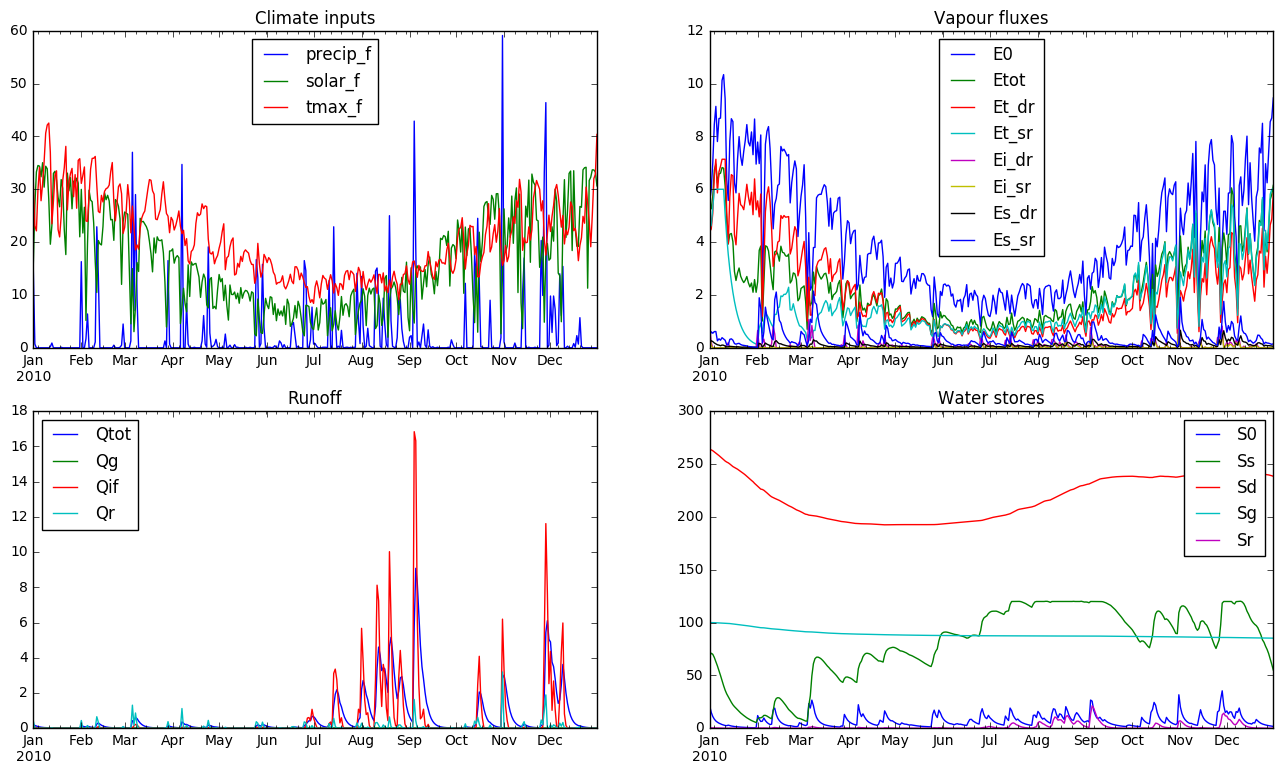

In [25]:
# plot outputs
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 2, figsize = (16,9))

df_clm.plot(x = df_clm.index, y = ['precip_f', 'solar_f', 'tmax_f'],ax = axarr [0,0],title='Climate inputs')
df_clm.plot(x = df_clm.index, y = ['E0', 'Etot', 'Et_dr','Et_sr','Ei_dr','Ei_sr','Es_dr','Es_sr'],ax = axarr [0,1],title='Vapour fluxes')
df_clm.plot(x = df_clm.index, y = ['Qtot', 'Qg', 'Qif', 'Qr'],ax = axarr [1,0],title='Runoff')
df_clm.plot(x = df_clm.index, y = ['S0', 'Ss','Sd', 'Sg','Sr'],ax = axarr [1,1],title='Water stores')


## Break: Morning tea

### Below demonstrates that the python version of the code reproduces the C results contained in the r object

In [26]:
# Names of variables avilable from standard awra simulation contained in r
r.keys()

dict_keys(['es_hrudr', 'mleaf_hrusr', 'ud_hrudr', 'fsat_hrudr', 'us_hrusr', 'sd_hrusr', 'et_hrudr', 'qtot', 'dd', 'ud_hrusr', 'y', 'sr', 'sg', 's0_hrusr', 'ss_hrudr', 'es_hrusr', 'ei_hrudr', 'fegt_hrusr', 's0', 'etot', 'qr', 'fsat_hrusr', 'final_states', 'e0', 'sd_hrudr', 'sd', 'et_hrusr', 'mleaf_hrudr', 'qg', 'ei_hrusr', 'ss', 'eg', 'us_hrudr', 'qif', 's0_hrudr', 'fegt_hrudr', 'ss_hrusr'])

In [27]:
# Names of variables avilable from python awra simulation
df_clm.keys()

Index(['Dd', 'E0', 'Eg', 'Ei_dr', 'Ei_sr', 'Es_dr', 'Es_sr', 'Et_dr', 'Et_sr',
       'Etot', 'Qg', 'Qif', 'Qr', 'Qtot', 'S0', 'Sd', 'Sg', 'Sr', 'Ss', 'Y',
       'fEgt', 'fEgt_dr', 'fEgt_sr', 'fsat', 'mleaf_dr', 'mleaf_sr',
       'precip_f', 'solar_f', 'tmax_f', 'tmin_f', 'u2t'],
      dtype='object')

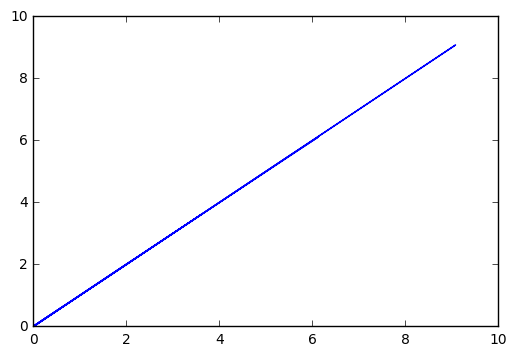

In [28]:
# Check if simulation from AWRAMS system matches Python code
plt.plot(r['qtot'],df_clm['Qtot'])

(array([], dtype=int64),)

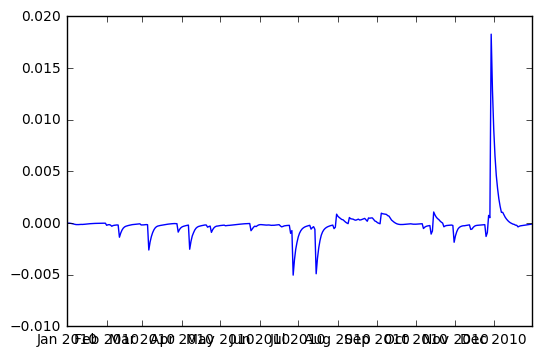

In [29]:
# Check if simulation from AWRAMS system matches Python code
# plot timeseries of differences in Qtot and give index of days where there is greater than 0.1mm difference in values 
x=r['qtot'][:,0]-df_clm['Qtot']
y=abs(x)
plt.plot(x)
np.where(y>.1)

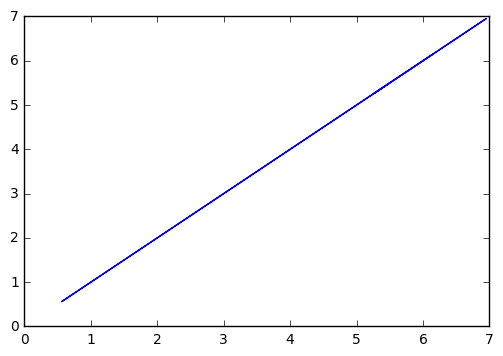

In [30]:
# Check if simulation from AWRAMS system matches Python code for Etot
plt.plot(r['etot'],df_clm['Etot'])

(array([], dtype=int64),)

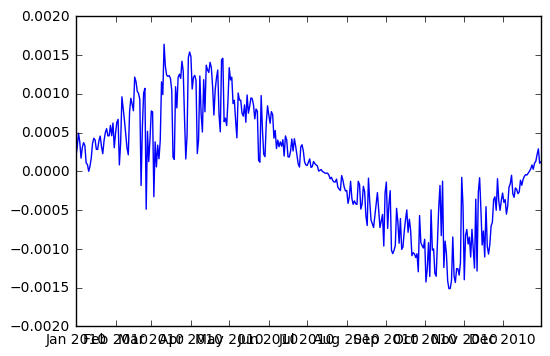

In [31]:
# plot timeseries of differences in Etot and give index of days where there is greater than 0.1mm difference in values 
x=r['etot'][:,0]-df_clm['Etot']
y=abs(x)
plt.plot(x)
np.where(y>.1)

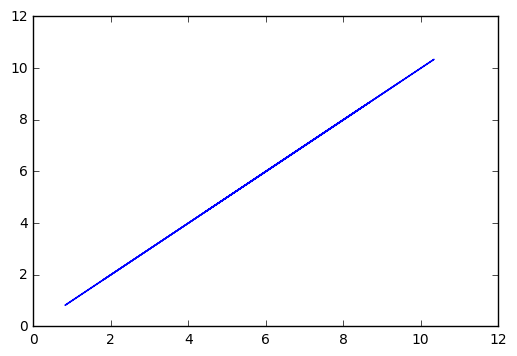

In [32]:
# potential evaporation E0
plt.plot(r['e0'],df_clm['E0'])

(array([], dtype=int64),)

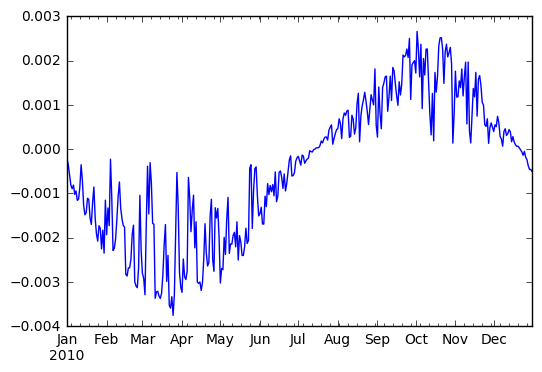

In [33]:
# plot timeseries of differences in E0 and give index of days where there is greater than 0.1mm difference in values 
x=df_clm['E0']-r['e0'][:,0]
y=abs(x)
x.plot()
np.where(y>.1)

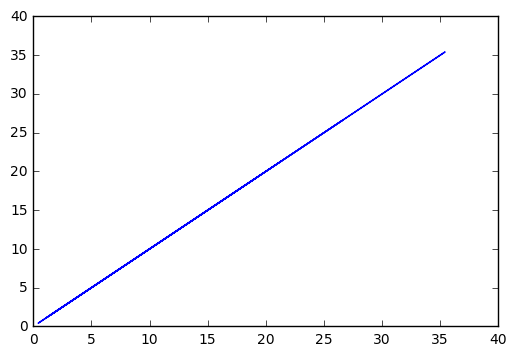

In [34]:
# top layer soil store
plt.plot(r['s0'],df_clm['S0'])

(array([], dtype=int64),)

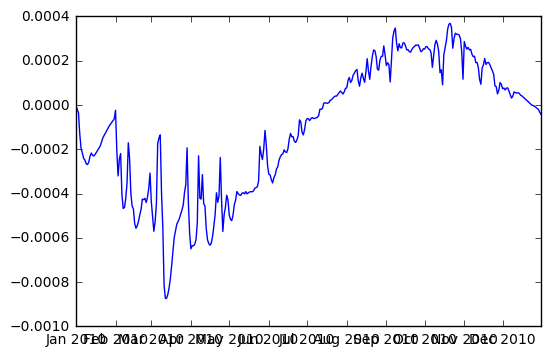

In [35]:
# plot timeseries of differences in s0 and give index of days where there is greater than 0.1mm difference in values 
x=r['s0'][:,0]-df_clm['S0']
y=abs(x)
plt.plot(x)
np.where(y>.1)

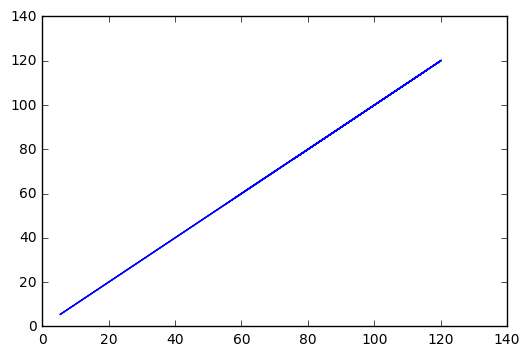

In [36]:
plt.plot(r['ss'],df_clm['Ss'])

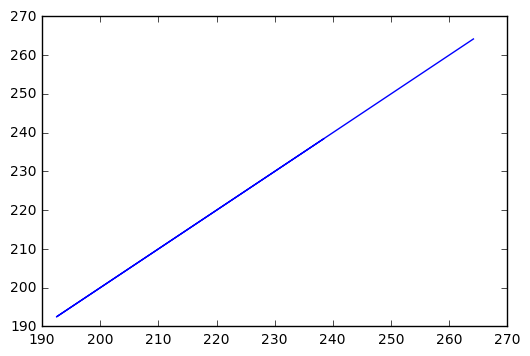

In [37]:
plt.plot(r['sd'],df_clm['Sd'])

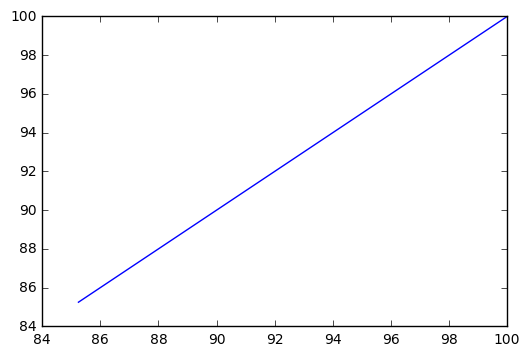

In [38]:
# Check if simulation from AWRAMS system matches Python code
plt.plot(r['sg'],df_clm['Sg'])

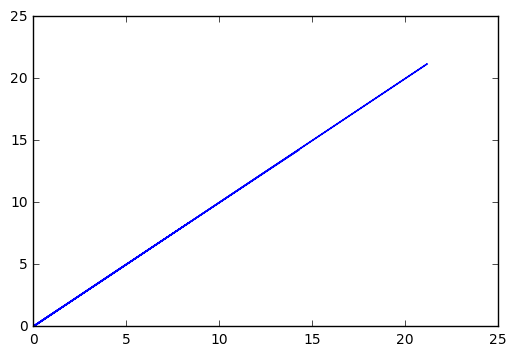

In [39]:
# Check if simulation from AWRAMS system matches Python code
plt.plot(r['sr'],df_clm['Sr'])

(array([], dtype=int64),)

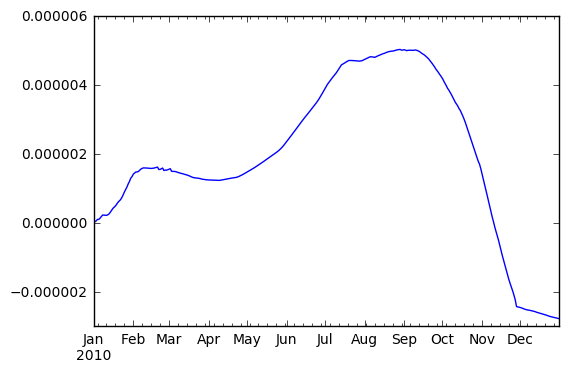

In [40]:
x=df_clm['Dd']-r['dd'][:,0]
y=abs(x)
x.plot()
np.where(y>.1)

(array([], dtype=int64),)

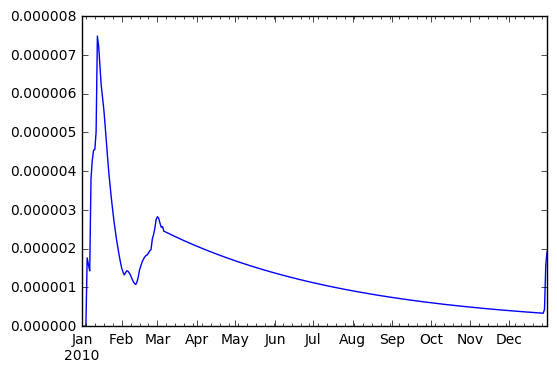

In [41]:
x=df_clm['mleaf_sr']-r['mleaf_hrusr'][:,0]
y=abs(x)
x.plot()
np.where(y>.1)

(array([], dtype=int64),)

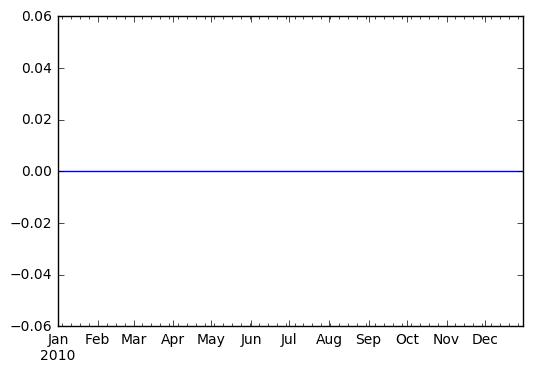

In [42]:
x=df_clm['mleaf_dr']-r['mleaf_hrudr'][:,0]
y=abs(x)
x.plot()
np.where(y>.1)